In [9]:
import numpy as np
import matplotlib.pyplot as plt
import math
import os

import torch

from simulate import simulate_convergence, simulate_merge, simulate_branching, simulate_deflection, simulate_ridge
# from kernels import divergence_free_se_kernel, block_diagonal_se_kernel 
from GP import predict, optimise_hypers_on_train
# optimize_hypers_on_train
from metrics import log_likelihood_test

torch.set_printoptions(sci_mode = False)
np.set_printoptions(suppress = True)

/home/kim/eccv/.conda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# ToDo
- Posterior sampling function
- Can swirling issue be fixed with lengthscale?
    - flow directional constraint?!
- solenoidal vector field == divergence free vector field == incompressible vector field
- anisotropy through lengthscale tensor

# Done
- We can now input 1D or 2D lengthscales if we want

# Notes
- Kernel does not work with absolute difference somehow

# Idea
- rather than model u, v, model the direction and magnitude
- Calculate pairwise angle between vectors.
- Prior mean function: What mean function can we use to avoid "counterflow" and swirling

# Define 2D X values (test & train coordinates)

- spanning [0, 1]

In [10]:
# grid discretisation over domain [0, 1] for x1 and x2
N_grid_x1 = 20 + 1 # 21 so steps are easy numbers
N_grid_x2 = N_grid_x1

N_grid = N_grid_x1 * N_grid_x2

x1 = np.linspace(0, 1, N_grid_x1) # x
x2 = np.linspace(0, 1, N_grid_x2) # y

# define distances (for divergence caluclations)
dx = 1 / (N_grid_x1 - 1)
dy = 1 / (N_grid_x2 - 1)

X1_test, X2_test = np.meshgrid(x1, x2)

# grid not flat
X_test_grid = torch.cat([torch.tensor(X1_test).unsqueeze(-1), torch.tensor(X2_test).unsqueeze(-1)], dim = -1)

X_test = X_test_grid.reshape(-1, 2)

### Fixed x locations

In [18]:
# Fixed training data points for now
X_train = torch.tensor([
    [0.8750, 0.1500, 0.2500, 0.5000, 0.3853, 0.9991, 0.4333, 0.1494, 0.6196, 0.7808, 0.5609, 0.5895, 0.3395, 0.7232],
    [0.6750, 0.9750, 0.9000, 0.3500, 0.6010, 0.3451, 0.7451, 0.8499, 0.6240, 0.7218, 0.8389, 0.1664, 0.9771, 0.0598]]).T

### Randomly sample x locations

In [4]:
# randomly sample locations 
# makes problems less pronounces
n_train = 14
X_train = torch.rand(n_train, 2)

In [9]:
simulation_functions = [simulate_deflection]

for simulation_func in simulation_functions:

    Y_train = simulation_func(X_train)

    # Noise
    make_some_noise = torch.tensor([0.05]) # reduce to zero to see what is going on
    Y_train_noisy = Y_train + make_some_noise * torch.randn_like(Y_train)

    # ground truth for metrics
    Y_test = simulation_func(X_test)

    ##############################
    ### Divergence-free kernel ###
    ##############################
    sigma_n = torch.tensor([0.01], requires_grad = False) # no optimisation for noise
    # sigma_f_squared= torch.tensor([0.01], requires_grad = True) # get's squared so does not matter if negative
    sigma_f = torch.tensor([0.05], requires_grad = True) # get's squared so does not matter if negative
    ### 2D lengthscale: needs so be a single value
    l = torch.tensor([0.5, 0.7], requires_grad = True)

    # list of 3 tensors
    initial_hyperparameters_df = [sigma_n, sigma_f, l]

    predictive_mean_df_initial, predictive_covar_df_initial, lml_df_initial = predict(
        X_train,
        Y_train_noisy,
        X_test, 
        initial_hyperparameters_df, # for now
        divergence_free_bool = True)

# Showcase hyperparam optimisation on divergence-free kernel

Initial RMSE on test: 0.302
Initial MAE on test: 0.171
Initial LL on test (higher is better): -69156.559

Initial hyperparameters: 0.010, 0.050, [0.6 0.5]
Initial LML (higher is better): -1465.18

Optimisation complete after 2000/2000 iterations. Maybe consider adjusting the optimisation scheme (e.g. learning rate, max iterations, patience, etc.).
Best hyperparameters: 0.010, 0.252, [0.34192133 0.32039115]
Best LML (higher is better): -5.61

Final RMSE on test: 0.442
Final MAE on test: 0.221
Final LL on test (higher is better): 434.605


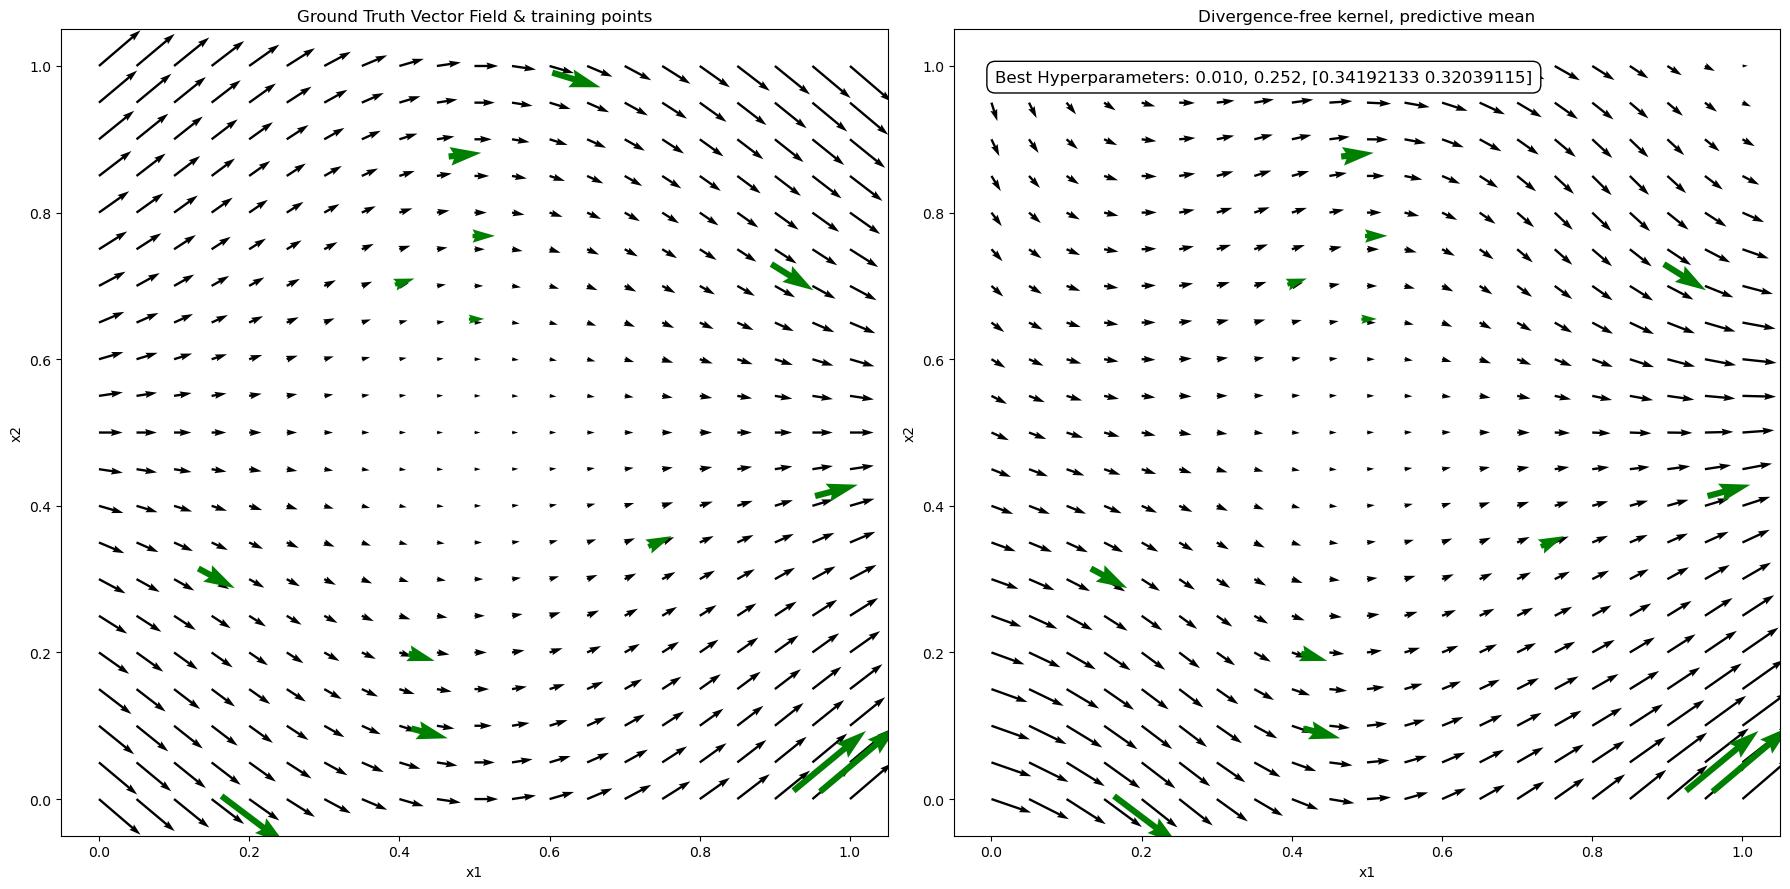

In [ ]:
simulation_functions = [simulate_ridge]
simulation_functions = [simulate_deflection]

for simulation_func in simulation_functions:

    Y_train = simulation_func(X_train)

    # Noise
    make_some_noise = torch.tensor([0.00]) # reduce to zero to see what is going on
    Y_train_noisy = Y_train + make_some_noise * torch.randn_like(Y_train)

    # ground truth for metrics
    Y_test = simulation_func(X_test)

    ##############################
    ### Divergence-free kernel ###
    ##############################
    sigma_n = torch.tensor([0.01], requires_grad = False) # no optimisation for noise
    # sigma_f_squared= torch.tensor([0.01], requires_grad = True) # get's squared so does not matter if negative
    sigma_f = torch.tensor([0.05], requires_grad = True) # get's squared so does not matter if negative
    # log_sigma_f_squared = torch.tensor([0.0], requires_grad = True) # initialise as 0
    l = torch.tensor([0.6, 0.5], requires_grad = True)

    # list of 3 tensors
    initial_hyperparameters_df = [sigma_n, sigma_f, l]

    predictive_mean_df_initial, predictive_covar_df_initial, lml_df_initial = predict(
        X_train,
        Y_train_noisy,
        X_test, 
        initial_hyperparameters_df, # for now
        divergence_free_bool = True)
    
    rmse_df = torch.sqrt(torch.mean(torch.square(predictive_mean_df_initial - Y_test)))
    mae_df = torch.mean(torch.abs(predictive_mean_df_initial - Y_test))
    ll_df = log_likelihood_test(predictive_mean_df_initial, predictive_covar_df_initial, Y_test)

    print(f'Initial RMSE on test: {rmse_df.item():.3f}')
    print(f'Initial MAE on test: {mae_df.item():.3f}')
    print(f'Initial LL on test (higher is better): {ll_df.item():.3f}')

    ### OPTIMIZE ###
    print()

    opt_hyperparameters_df, lml_log = optimise_hypers_on_train(
        initial_hyperparameters_df, 
        X_train, 
        Y_train_noisy, 
        X_test,
        divergence_free_bool = True)

    predictive_mean_df, predictive_covar_df, lml_df = predict(
        X_train,
        Y_train_noisy,
        X_test, 
        opt_hyperparameters_df,
        divergence_free_bool = True)
    
    rmse_df = torch.sqrt(torch.mean(torch.square(predictive_mean_df - Y_test)))
    mae_df = torch.mean(torch.abs(predictive_mean_df - Y_test))
    ll_df = log_likelihood_test(predictive_mean_df, predictive_covar_df, Y_test)

    print()
    print(f'Final RMSE on test: {rmse_df.item():.3f}')
    print(f'Final MAE on test: {mae_df.item():.3f}')
    print(f'Final LL on test (higher is better): {ll_df.item():.3f}')

    formatted_hypers = []
    for h in opt_hyperparameters_df:  # Use optimized hyperparameters
        h_np = h.detach().numpy()
        if h_np.ndim == 0:  # Scalar tensor
            formatted_hypers.append(f"{h_np:.3f}")
        elif h_np.ndim == 1 and h_np.shape[0] == 1:  # Single-element 1D tensor
            formatted_hypers.append(f"{h_np[0]:.3f}")
        else:  # Higher-dimensional tensors (e.g., matrices)
            formatted_hypers.append(str(h_np))

    # Add formatted hyperparameters to the plot
    hyperparams_text = f"Best Hyperparameters: {', '.join(formatted_hypers)}"
    
    fig, axes = plt.subplots(1, 2, figsize = (18, 9))  # 1 row, 3 columns

    # First plot: Ground truth vector field
    axes[0].quiver(X_test[:, 0], X_test[:, 1], Y_test[:, 0], Y_test[:, 1], color = 'black')
    axes[0].quiver(X_train[:, 0], X_train[:, 1], Y_train[:, 0], Y_train[:, 1], color = 'green', label = 'Training Data')
    axes[0].set_title('Ground Truth Vector Field & training points')
    axes[0].set_xlabel('x1')
    axes[0].set_ylabel('x2')

    # Second plot: Noisy training observations
    axes[1].quiver(X_test[:, 0], X_test[:, 1], predictive_mean_df.detach().numpy()[:, 0], predictive_mean_df.detach().numpy()[:, 1], color = 'black')
    axes[1].quiver(X_train[:, 0], X_train[:, 1], Y_train[:, 0], Y_train[:, 1], color = 'green', label = 'Training Data')
    axes[1].text(0.05, 0.95, hyperparams_text, transform = axes[1].transAxes, fontsize = 12, verticalalignment = 'top', color = 'black', bbox = dict(facecolor='white', edgecolor = 'black', boxstyle = 'round, pad=0.5'))
    axes[1].set_title('Divergence-free kernel, predictive mean')
    axes[1].set_xlabel('x1')
    axes[1].set_ylabel('x2')

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()

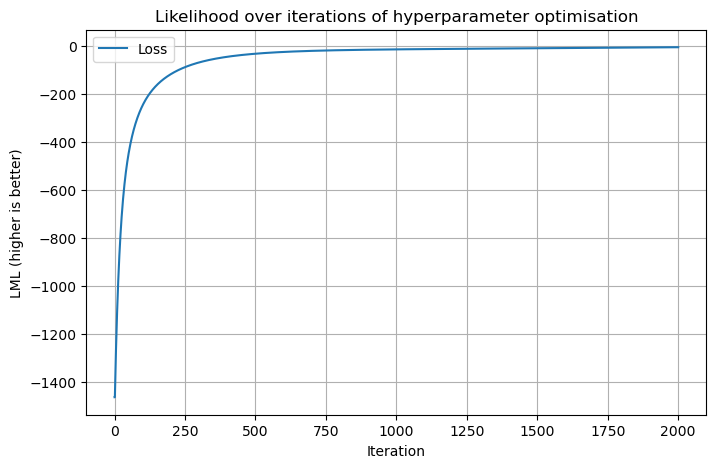

In [10]:
plt.figure(figsize = (8, 5))
plt.plot(lml_log, label = "Loss")
plt.xlabel("Iteration")
plt.ylabel("LML (higher is better)")
plt.title("Likelihood over iterations of hyperparameter optimisation")
plt.legend()
plt.grid()
plt.show()

## Check data distribution of y_test

We do not strictly "normalise" the data but we achieve a roughly uniform range of values so that sigma_f are within the same range.

In [11]:
simulation_functions = [simulate_convergence, simulate_merge, simulate_branching, simulate_deflection, simulate_ridge]
# simulation_functions = [simulate_convergence]

for simulation_func in simulation_functions:

    # Y_train = simulation_func(X_train)
    Y_test = simulation_func(X_test)

    print()
    print(f"Simulation Function: {str(simulation_func).split()[1]}")
    print(f"Mean of Y_test: {Y_test.mean().item():.4f}")
    print(f"Std of Y_test: {Y_test.std().item():.4f}")
    # divide deflection by 10


Simulation Function: simulate_convergence
Mean of Y_test: 0.5000
Std of Y_test: 0.3029

Simulation Function: simulate_merge
Mean of Y_test: 0.8484
Std of Y_test: 0.5489

Simulation Function: simulate_branching
Mean of Y_test: -0.1104
Std of Y_test: 0.4641

Simulation Function: simulate_deflection
Mean of Y_test: 0.4800
Std of Y_test: 0.7317

Simulation Function: simulate_ridge
Mean of Y_test: 0.5745
Std of Y_test: 1.0831


In [ ]:
# list of simulation functions
# simulation_functions = [simulate_convergence, simulate_merge, simulate_branching, simulate_deflection, simulate_ridge]
# simulation_functions = [simulate_convergence]
simulation_functions = [simulate_ridge]

for simulation_func in simulation_functions:

    Y_train = simulation_func(X_train)

    # Noise
    make_some_noise = torch.tensor([0.00])
    Y_train_noisy = Y_train + make_some_noise * torch.randn_like(Y_train)

    # ground truth for metrics
    Y_test = simulation_func(X_test)

    ##############################
    ### Divergence-free kernel ###
    ##############################
    print("Divergence-free kernel")
    sigma_n = torch.tensor([0.05], requires_grad = False) # no optimisation for noise
    sigma_f = torch.tensor([0.05], requires_grad = True) # initialise
    l = torch.tensor([0.8], requires_grad = True)

    # list of 3 tensors
    initial_hyperparameters_df = [sigma_n, sigma_f, l]

    opt_hyperparameters_df, _ = optimise_hypers_on_train(
        initial_hyperparameters_df, 
        X_train, 
        Y_train_noisy, 
        X_test,
        divergence_free_bool = True)

    predictive_mean_df, predictive_covar_df, nlml_df = predict(
        X_train,
        Y_train_noisy,
        X_test, 
        opt_hyperparameters_df,
        divergence_free_bool = True)
    
    rmse_df = torch.sqrt(torch.mean(torch.square(predictive_mean_df - Y_test)))
    mae_df = torch.mean(torch.abs(predictive_mean_df - Y_test))
    ll_df = log_likelihood_test(predictive_mean_df, predictive_covar_df, Y_test)

    print(f"RMSE: {rmse_df.item():.4f}, MAE: {mae_df.item():.4f}, Log-Likelihood: {ll_df.item():.4f}")
    print()

    ##################################
    ### Squared-exponential kernel ###
    ##################################

    print("Regular SE kernel")

    # Initialise again
    sigma_n = torch.tensor([0.05], requires_grad = False)
    sigma_f = torch.tensor([0.05], requires_grad = True)
    l = torch.tensor([0.6, 0.6], requires_grad = True)
    B = torch.tensor([[1.0, 0.0], [0.0, 1.0]], requires_grad = False) # fixed for now
    
    initial_hyperparameters_bd = [sigma_n, sigma_f, l, B]

    opt_hyperparameters_bd, _ = optimise_hypers_on_train(
        initial_hyperparameters_bd, 
        X_train, 
        Y_train_noisy, 
        X_test,
        divergence_free_bool = False)
    
    # print(opt_hyperparameters_bd)

    predictive_mean_bd, predictive_covar_bd, nlml_bd = predict(
        X_train,
        Y_train_noisy,
        X_test, 
        initial_hyperparameters_bd,
        divergence_free_bool = False) # other mode
    
    rmse_bd = torch.sqrt(torch.mean(torch.square(predictive_mean_bd - Y_test)))
    mae_bd = torch.mean(torch.abs(predictive_mean_bd - Y_test))
    ll_bd = log_likelihood_test(predictive_mean_bd, predictive_covar_bd, Y_test)

    print(f"RMSE: {rmse_bd.item():.4f}, MAE: {mae_bd.item():.4f}, Log-Likelihood: {ll_bd.item():.4f}")

    fig, axes = plt.subplots(1, 3, figsize = (18, 6))  # 1 row, 3 columns

    # First plot: Ground truth vector field
    axes[0].quiver(X_test[:, 0], X_test[:, 1], Y_test[:, 0], Y_test[:, 1], color = 'black')
    axes[0].quiver(X_train[:, 0], X_train[:, 1], Y_train[:, 0], Y_train[:, 1], color = 'green', label = 'Training Data')
    axes[0].set_title('Ground Truth Vector Field & training points')
    axes[0].set_xlabel('x1')
    axes[0].set_ylabel('x2')

    # Second plot: Kernel 1
    axes[1].quiver(X_test[:, 0], X_test[:, 1], predictive_mean_df.detach().numpy()[:, 0], predictive_mean_df.detach().numpy()[:, 1], color = 'black')
    axes[1].quiver(X_train[:, 0], X_train[:, 1], Y_train[:, 0], Y_train[:, 1], color = 'green', label = 'Training Data')
    axes[1].set_title('Divergence-free kernel, predictive mean')
    axes[1].set_xlabel('x1')
    axes[1].set_ylabel('x2')

    # Third plot: Kernel 2
    axes[2].quiver(X_test[:, 0], X_test[:, 1], predictive_mean_bd.detach().numpy()[:, 0], predictive_mean_bd.detach().numpy()[:, 1], color = 'black')
    axes[2].quiver(X_train[:, 0], X_train[:, 1], Y_train[:, 0], Y_train[:, 1], color = 'green', label = 'Training Data')
    axes[2].set_title('Block diagonal SE kernel, predictive mean')
    axes[2].set_xlabel('x1')
    axes[2].set_ylabel('x2')

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()
    
    # visualise_data(
    #    X_test, 
    #    Y_test,
    #    X_train, 
    #    Y_train_noisy)

# EXPORT: Cross-covariance kernel

u and v are related, for instance via magnitude?!
rather, here we just estimate how much they are related.

Divergence-free kernel
Initial hyperparameters: 0.050, 0.300, [0.7 0.7]
Initial LML (higher is better): 31.00

Optimisation complete after 2000/2000 iterations. Maybe consider adjusting the optimisation scheme (e.g. learning rate, max iterations, patience, etc.).
Best hyperparameters: 0.050, 1.145, [1.6064675 1.6608754]
Best LML (higher is better): 39.89
RMSE: 0.0572, MAE: 0.0465, Log-Likelihood: 1306.7933

Regular SE kernel
Initial hyperparameters: 0.050, 1.000, [0.7 0.7], [[0.3 0.1]
 [0.1 0.3]]
Initial LML (higher is better): 29.31

Optimisation complete after 2000/2000 iterations. Maybe consider adjusting the optimisation scheme (e.g. learning rate, max iterations, patience, etc.).
Best hyperparameters: 0.050, 1.000, [1.2708062 1.389255 ], [[1.0501844  0.0418938 ]
 [0.04189608 0.72740906]]
Best LML (higher is better): 38.46
RMSE: 0.1064, MAE: 0.0686, Log-Likelihood: 1077.9592


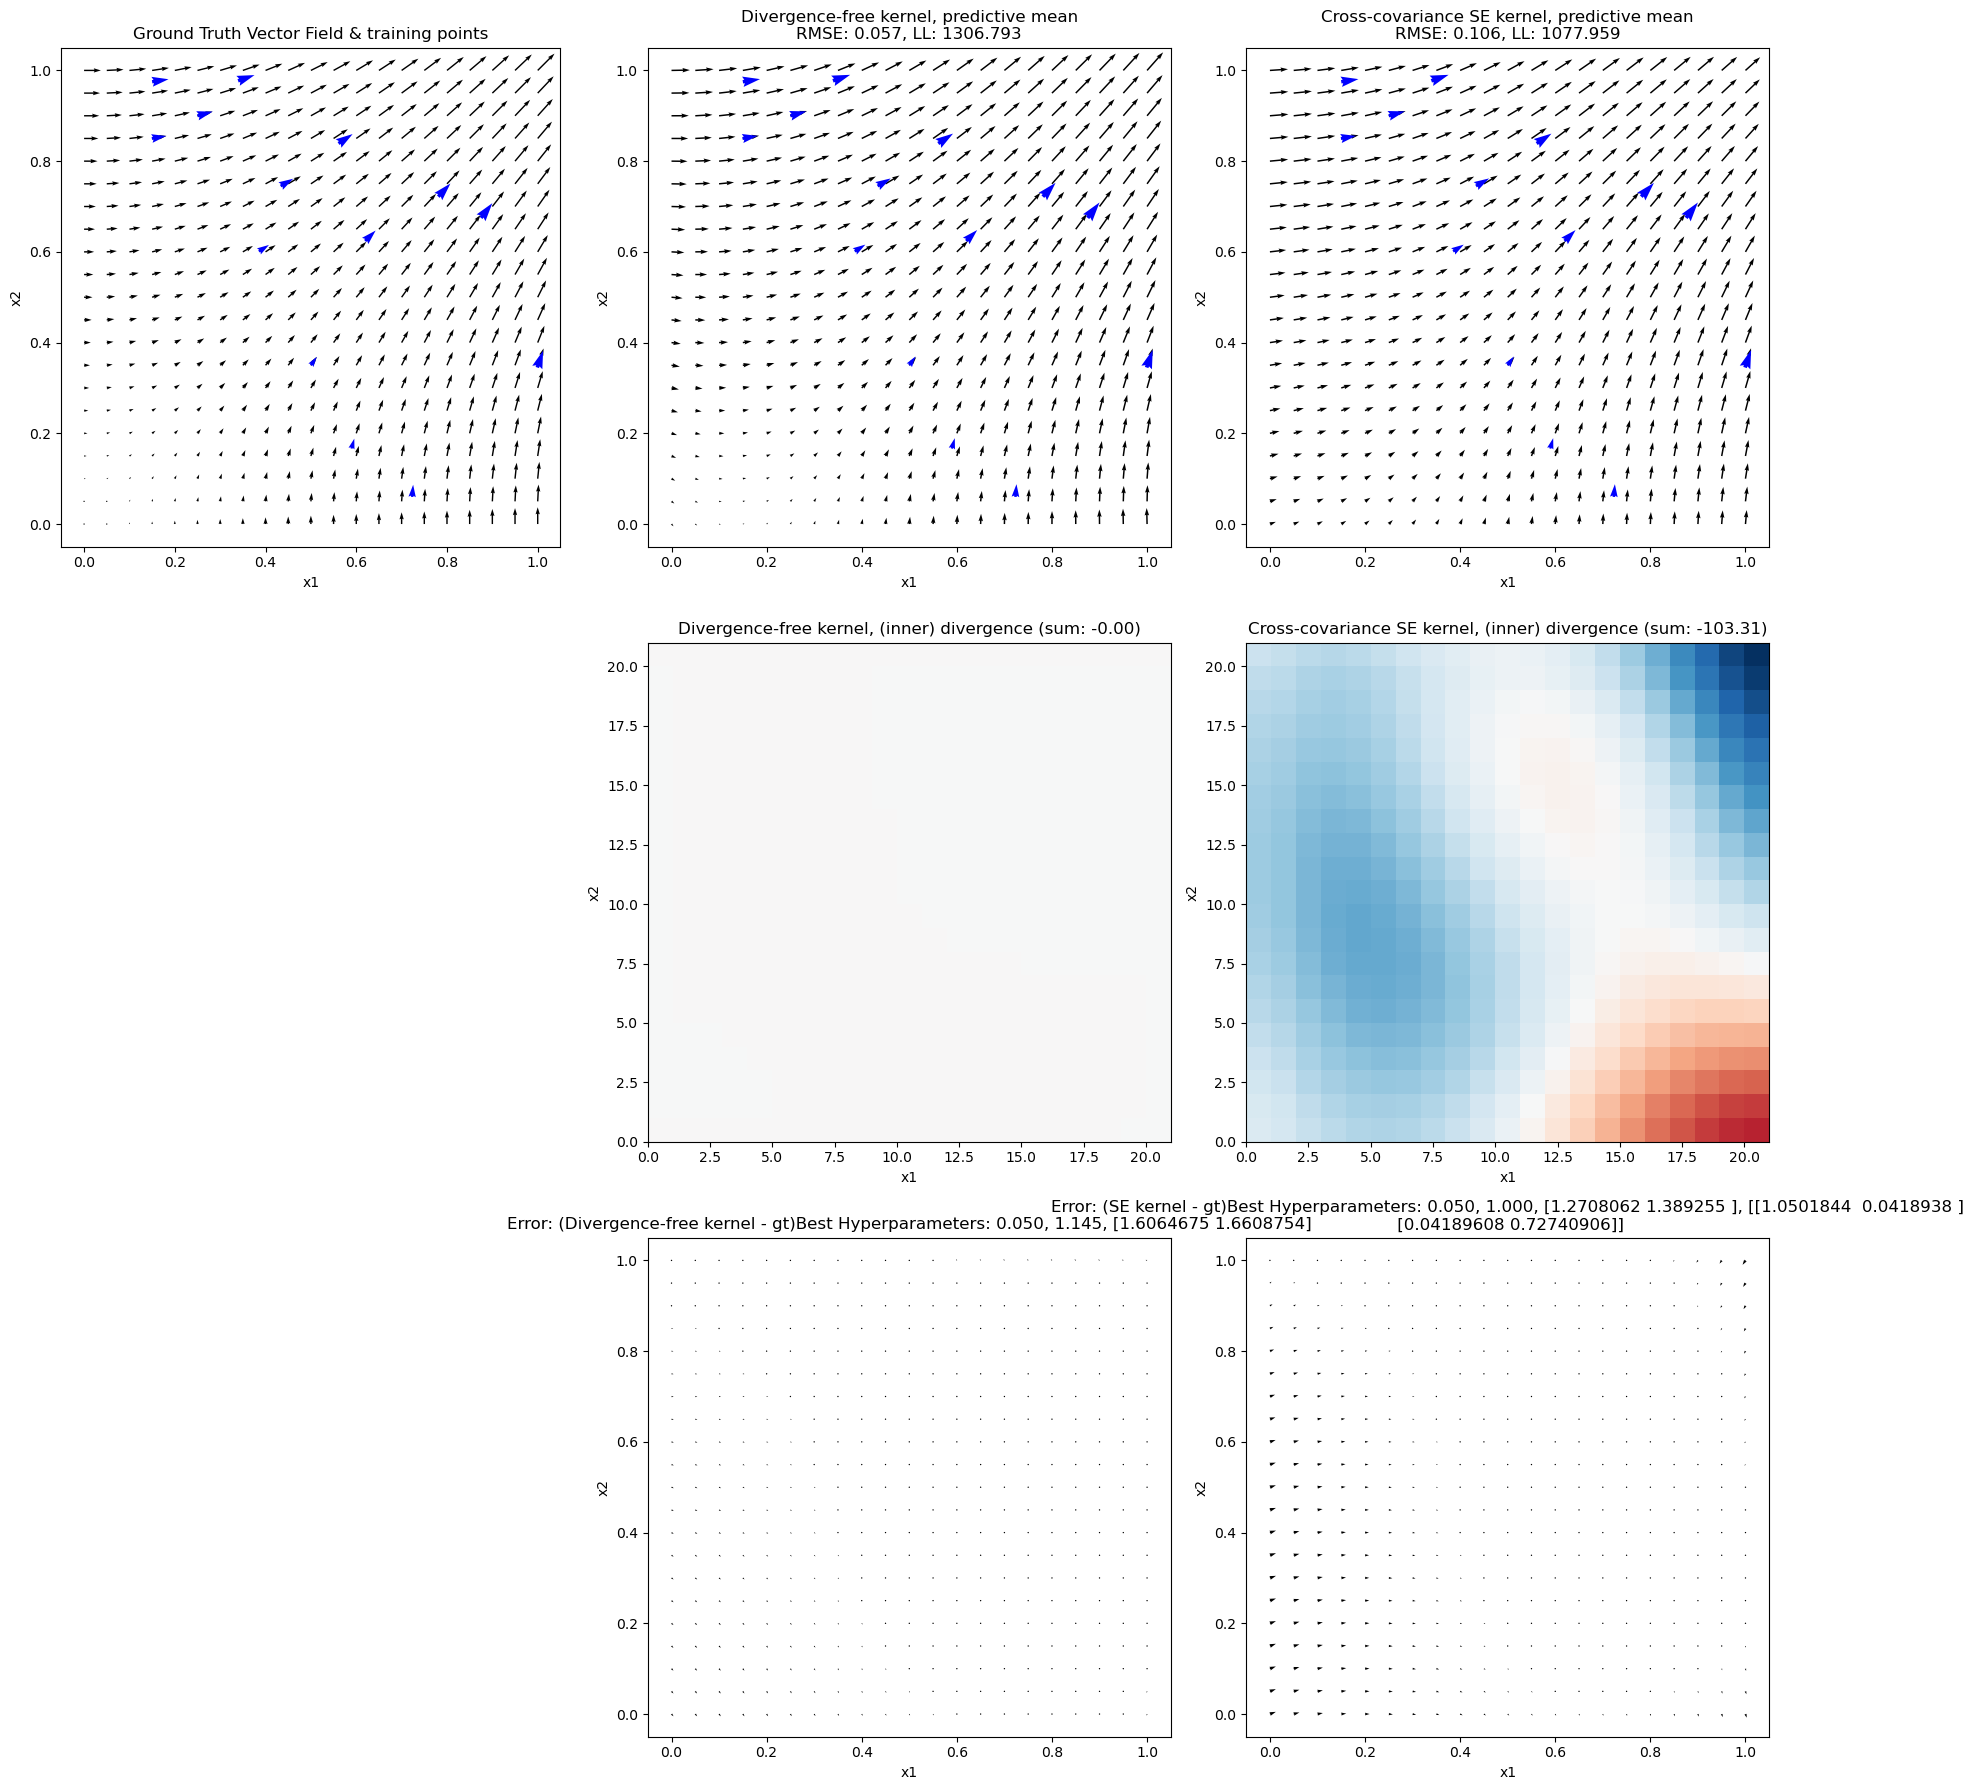

<Figure size 640x480 with 0 Axes>

Divergence-free kernel
Initial hyperparameters: 0.050, 0.300, [0.7 0.7]
Initial LML (higher is better): 13.05

Optimisation complete after 2000/2000 iterations. Maybe consider adjusting the optimisation scheme (e.g. learning rate, max iterations, patience, etc.).
Best hyperparameters: 0.050, 0.906, [0.84334725 0.872831  ]
Best LML (higher is better): 30.67
RMSE: 0.0491, MAE: 0.0378, Log-Likelihood: 1522.0258

Regular SE kernel
Initial hyperparameters: 0.050, 1.000, [0.7 0.7], [[0.3 0.1]
 [0.1 0.3]]
Initial LML (higher is better): 19.57

Optimisation complete after 2000/2000 iterations. Maybe consider adjusting the optimisation scheme (e.g. learning rate, max iterations, patience, etc.).
Best hyperparameters: 0.050, 1.000, [0.7278983  0.91793287], [[1.184565   0.1107942 ]
 [0.11079773 0.5608805 ]]
Best LML (higher is better): 27.30
RMSE: 0.1051, MAE: 0.0692, Log-Likelihood: 1017.6412


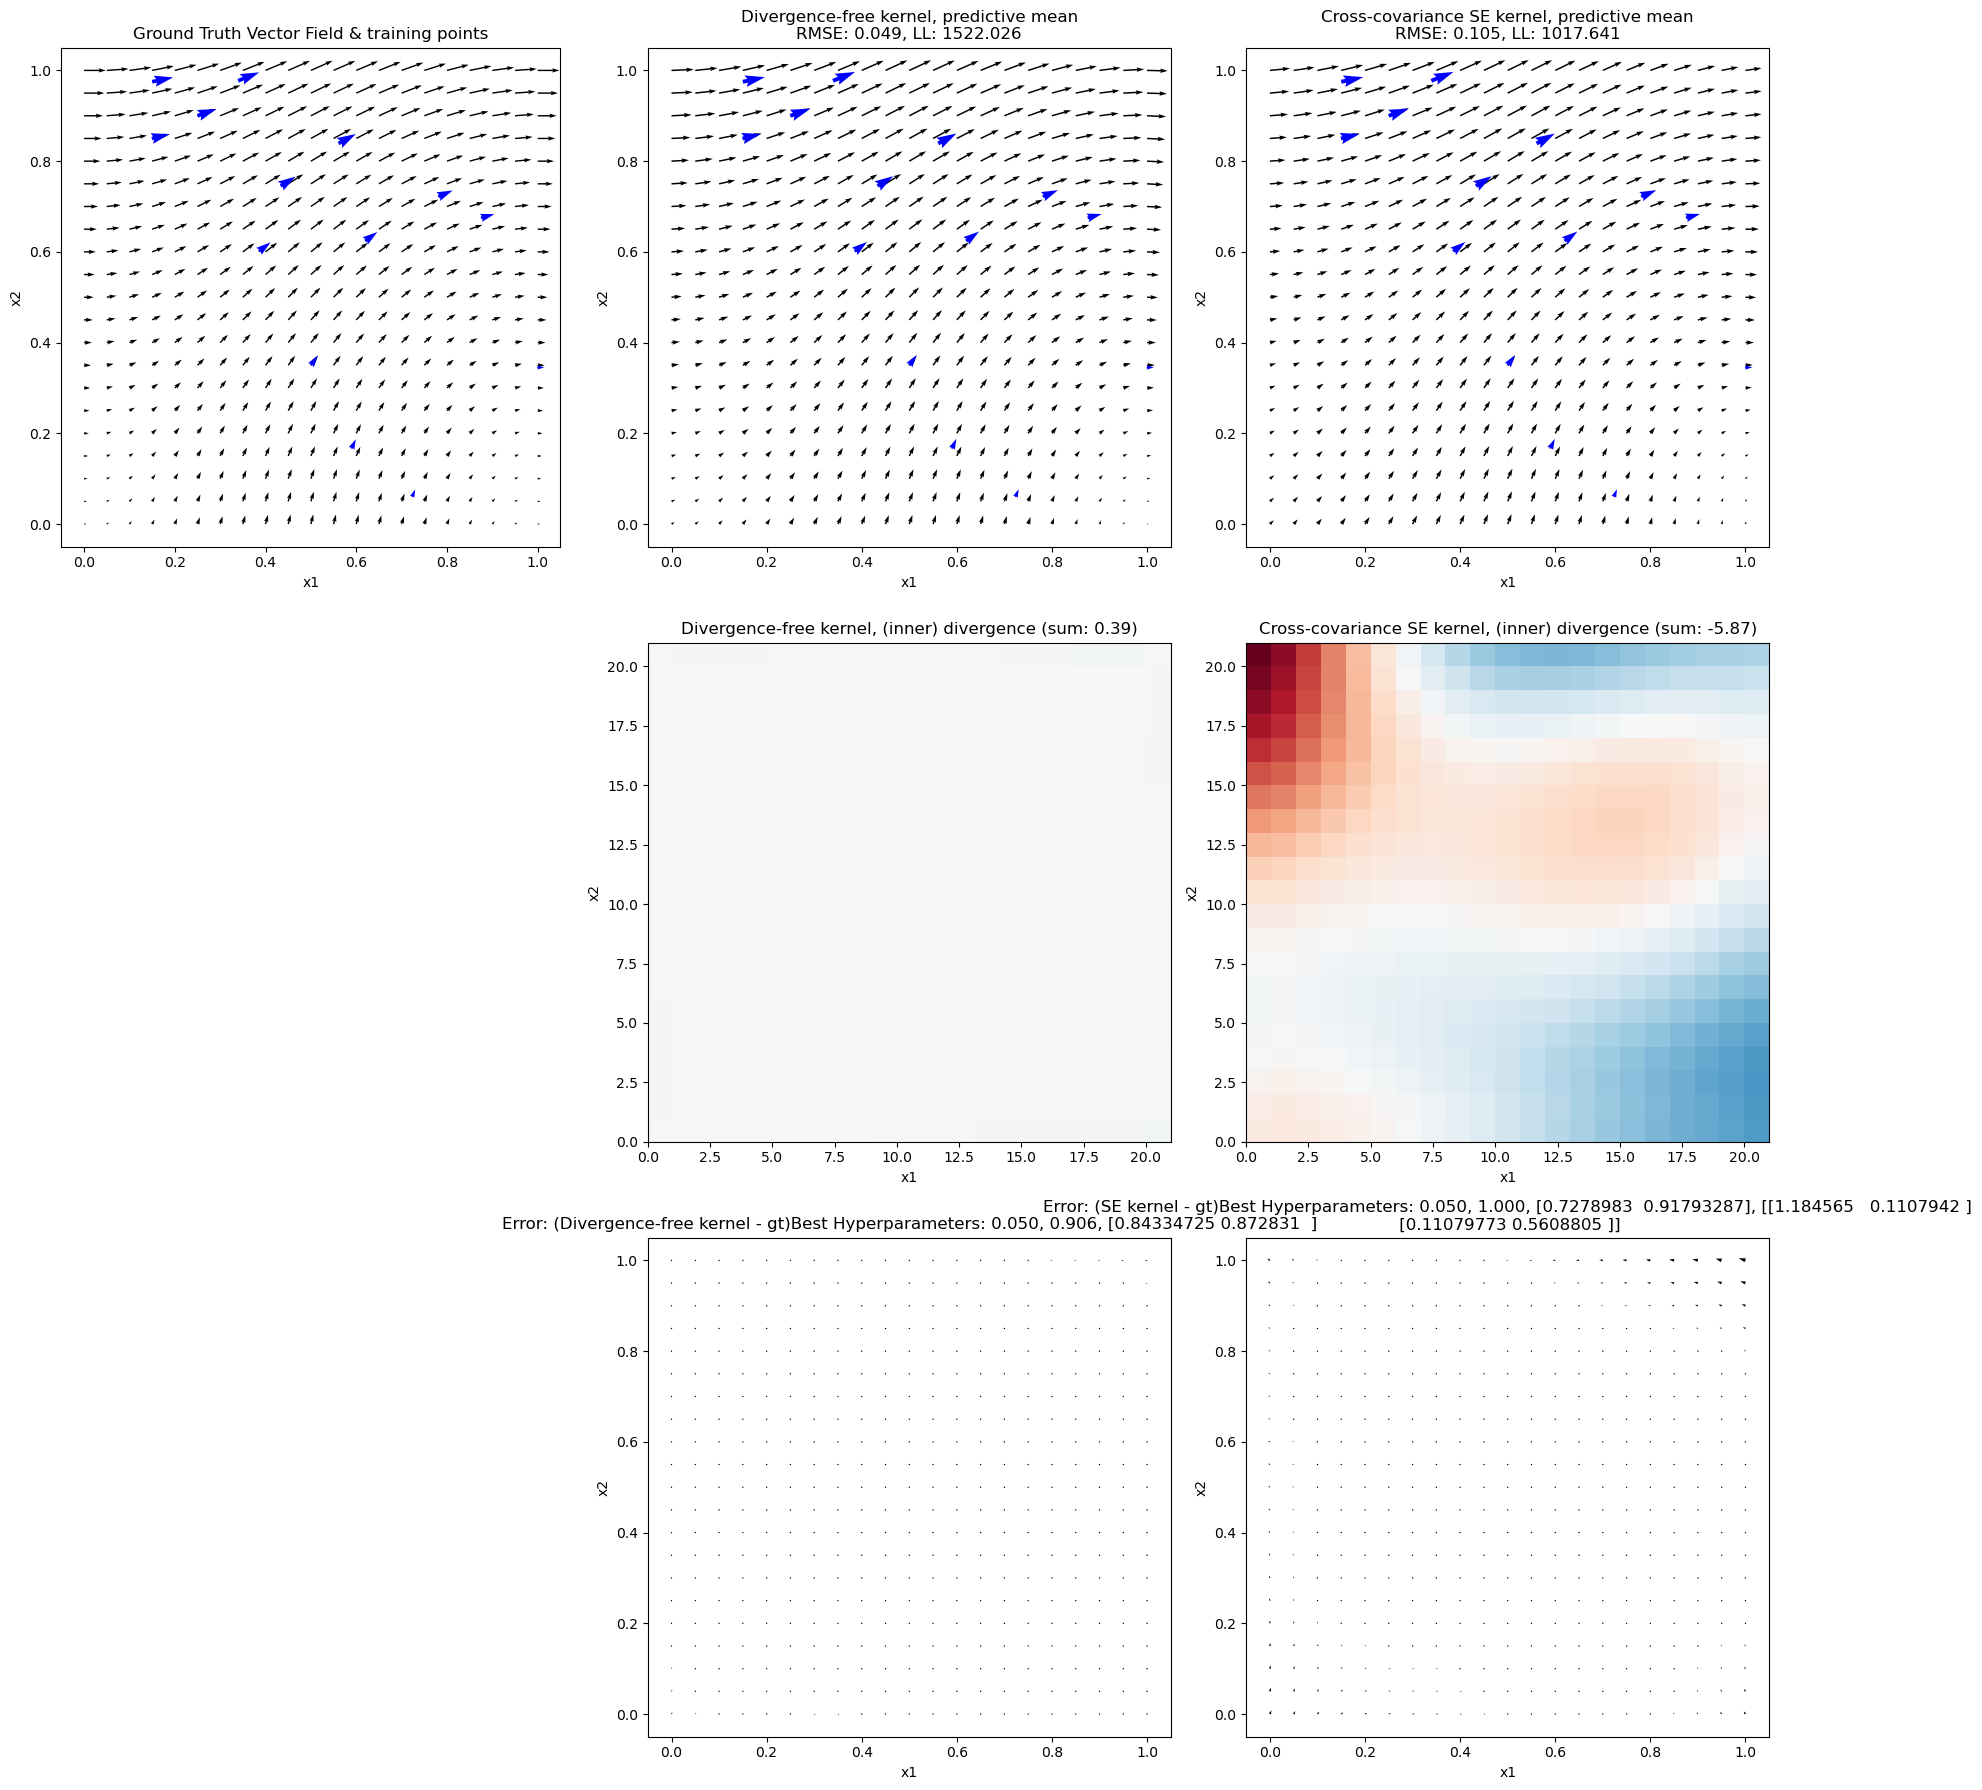

<Figure size 640x480 with 0 Axes>

Divergence-free kernel
Initial hyperparameters: 0.050, 0.300, [0.7 0.7]
Initial LML (higher is better): 37.60

Optimisation complete after 2000/2000 iterations. Maybe consider adjusting the optimisation scheme (e.g. learning rate, max iterations, patience, etc.).
Best hyperparameters: 0.050, 1.128, [1.5317564 1.6576996]
Best LML (higher is better): 41.85
RMSE: 0.0813, MAE: 0.0565, Log-Likelihood: 1360.0917

Regular SE kernel
Initial hyperparameters: 0.050, 1.000, [0.7 0.7], [[0.3 0.1]
 [0.1 0.3]]
Initial LML (higher is better): 33.16

Optimisation complete after 2000/2000 iterations. Maybe consider adjusting the optimisation scheme (e.g. learning rate, max iterations, patience, etc.).
Best hyperparameters: 0.050, 1.000, [1.1222007 1.0435015], [[0.27543694 0.17535049]
 [0.17525756 0.6837665 ]]
Best LML (higher is better): 41.13
RMSE: 0.1214, MAE: 0.0801, Log-Likelihood: 1050.2530


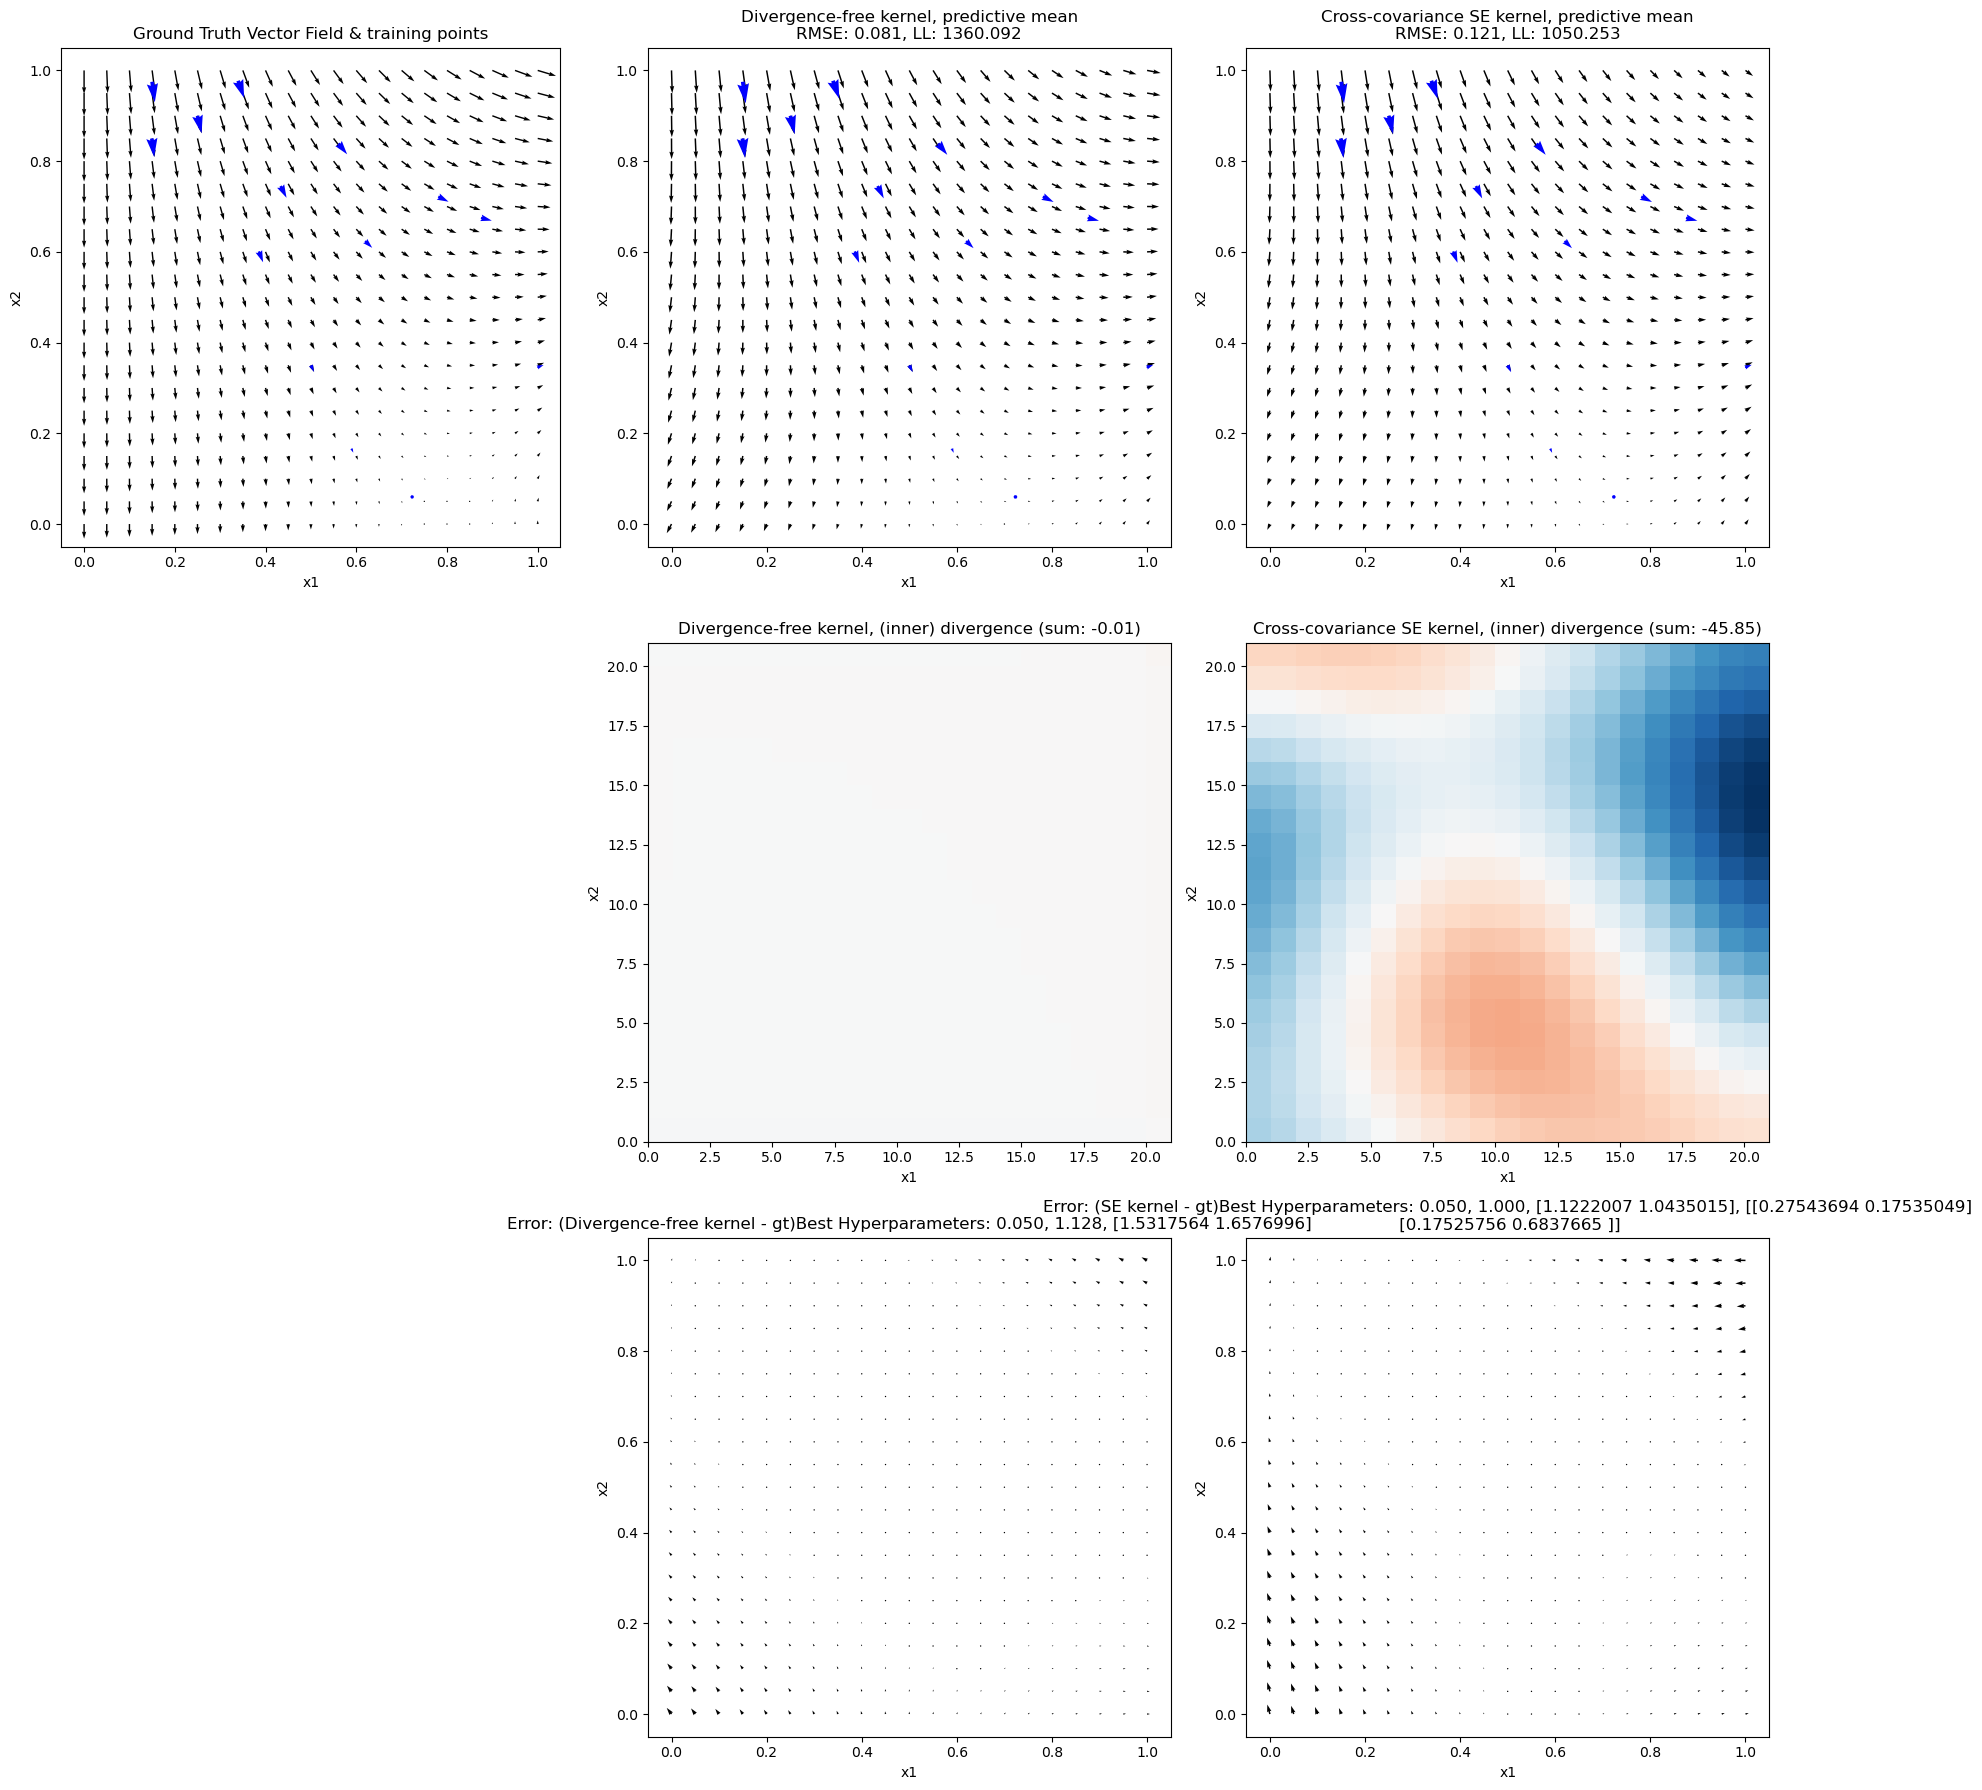

<Figure size 640x480 with 0 Axes>

Divergence-free kernel
Initial hyperparameters: 0.050, 0.300, [0.7 0.7]
Initial LML (higher is better): -17.08

Optimisation complete after 2000/2000 iterations. Maybe consider adjusting the optimisation scheme (e.g. learning rate, max iterations, patience, etc.).
Best hyperparameters: 0.050, 0.738, [0.50885814 0.59874594]
Best LML (higher is better): 16.80
RMSE: 0.3777, MAE: 0.1984, Log-Likelihood: 780.4822

Regular SE kernel
Initial hyperparameters: 0.050, 1.000, [0.7 0.7], [[0.3 0.1]
 [0.1 0.3]]
Initial LML (higher is better): 8.62

Optimisation complete after 2000/2000 iterations. Maybe consider adjusting the optimisation scheme (e.g. learning rate, max iterations, patience, etc.).
Best hyperparameters: 0.050, 1.000, [0.7955339  0.80700296], [[1.1827341  0.44012654]
 [0.44014058 1.3342474 ]]
Best LML (higher is better): 17.46
RMSE: 0.3518, MAE: 0.2075, Log-Likelihood: -615.9725


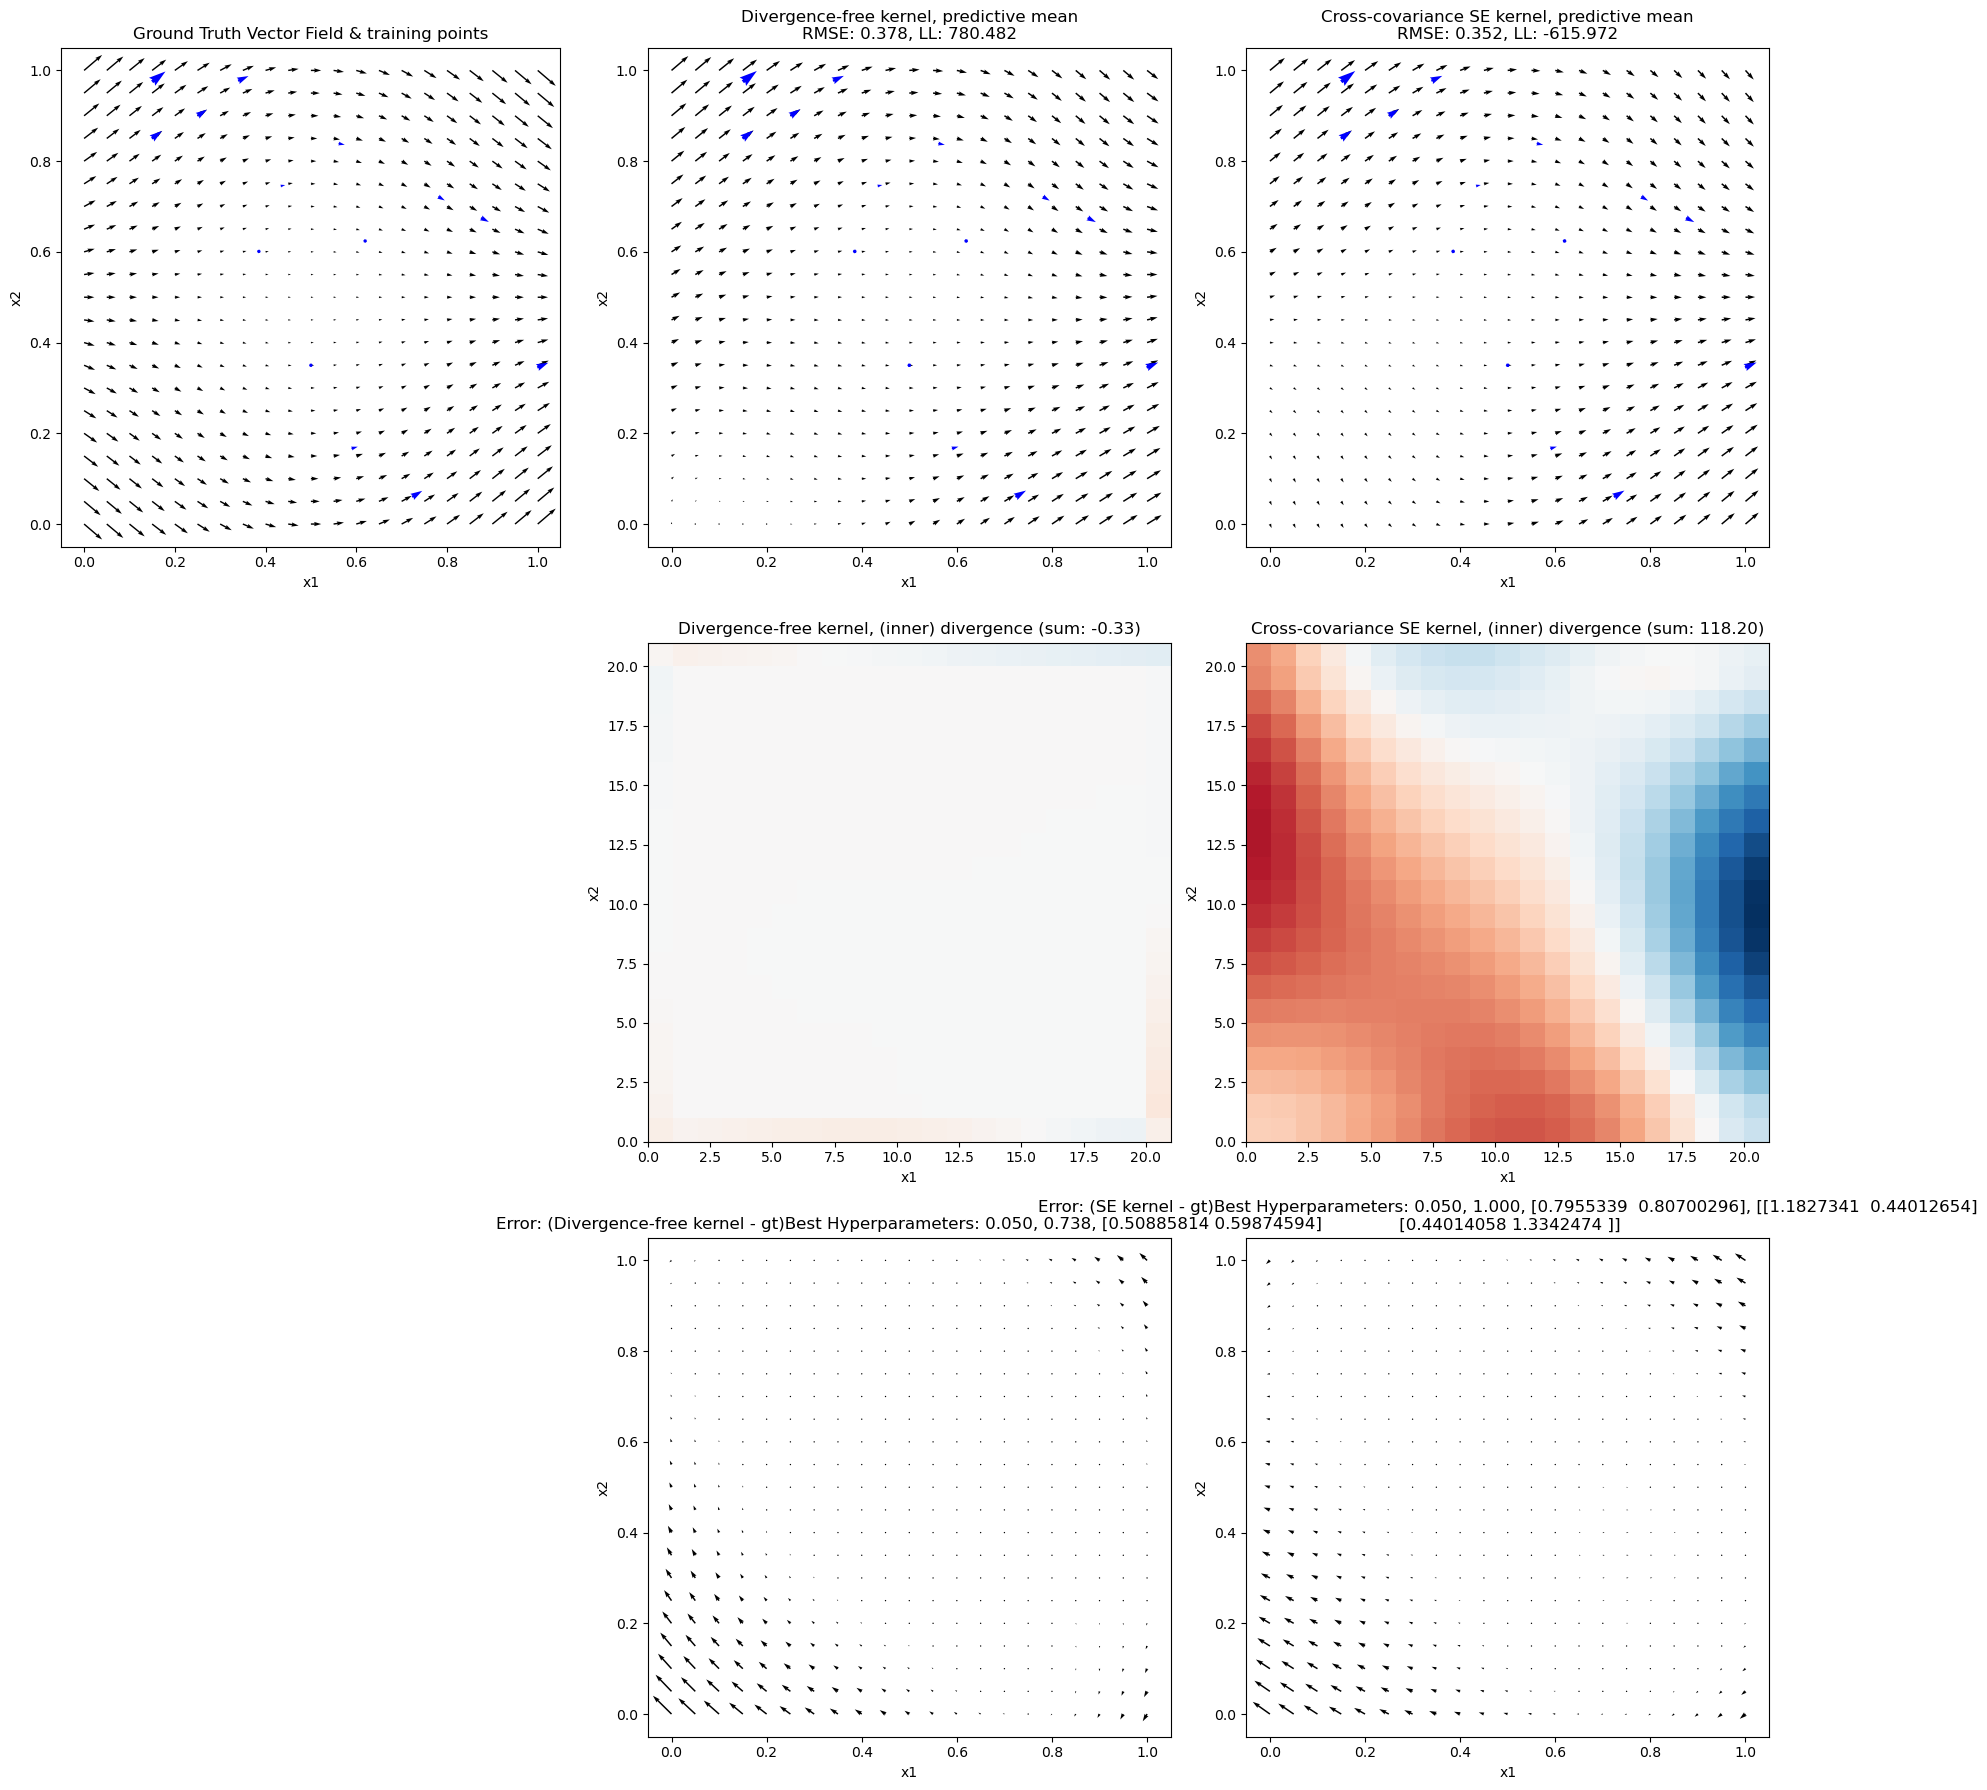

<Figure size 640x480 with 0 Axes>

Divergence-free kernel
Initial hyperparameters: 0.050, 0.300, [0.7 0.7]
Initial LML (higher is better): -487.48

Optimisation complete after 2000/2000 iterations. Maybe consider adjusting the optimisation scheme (e.g. learning rate, max iterations, patience, etc.).
Best hyperparameters: 0.050, 0.523, [0.27288377 0.32763135]
Best LML (higher is better): -14.48
RMSE: 0.7827, MAE: 0.5052, Log-Likelihood: -683.7698

Regular SE kernel
Initial hyperparameters: 0.050, 1.000, [0.7 0.7], [[0.3 0.1]
 [0.1 0.3]]
Initial LML (higher is better): -233.48

Optimisation complete after 2000/2000 iterations. Maybe consider adjusting the optimisation scheme (e.g. learning rate, max iterations, patience, etc.).
Best hyperparameters: 0.050, 1.000, [0.40972367 0.6318543 ], [[ 0.8608729  -0.12637408]
 [-0.1263737   0.73200864]]
Best LML (higher is better): -10.90
RMSE: 0.6828, MAE: 0.4261, Log-Likelihood: -28467.1576


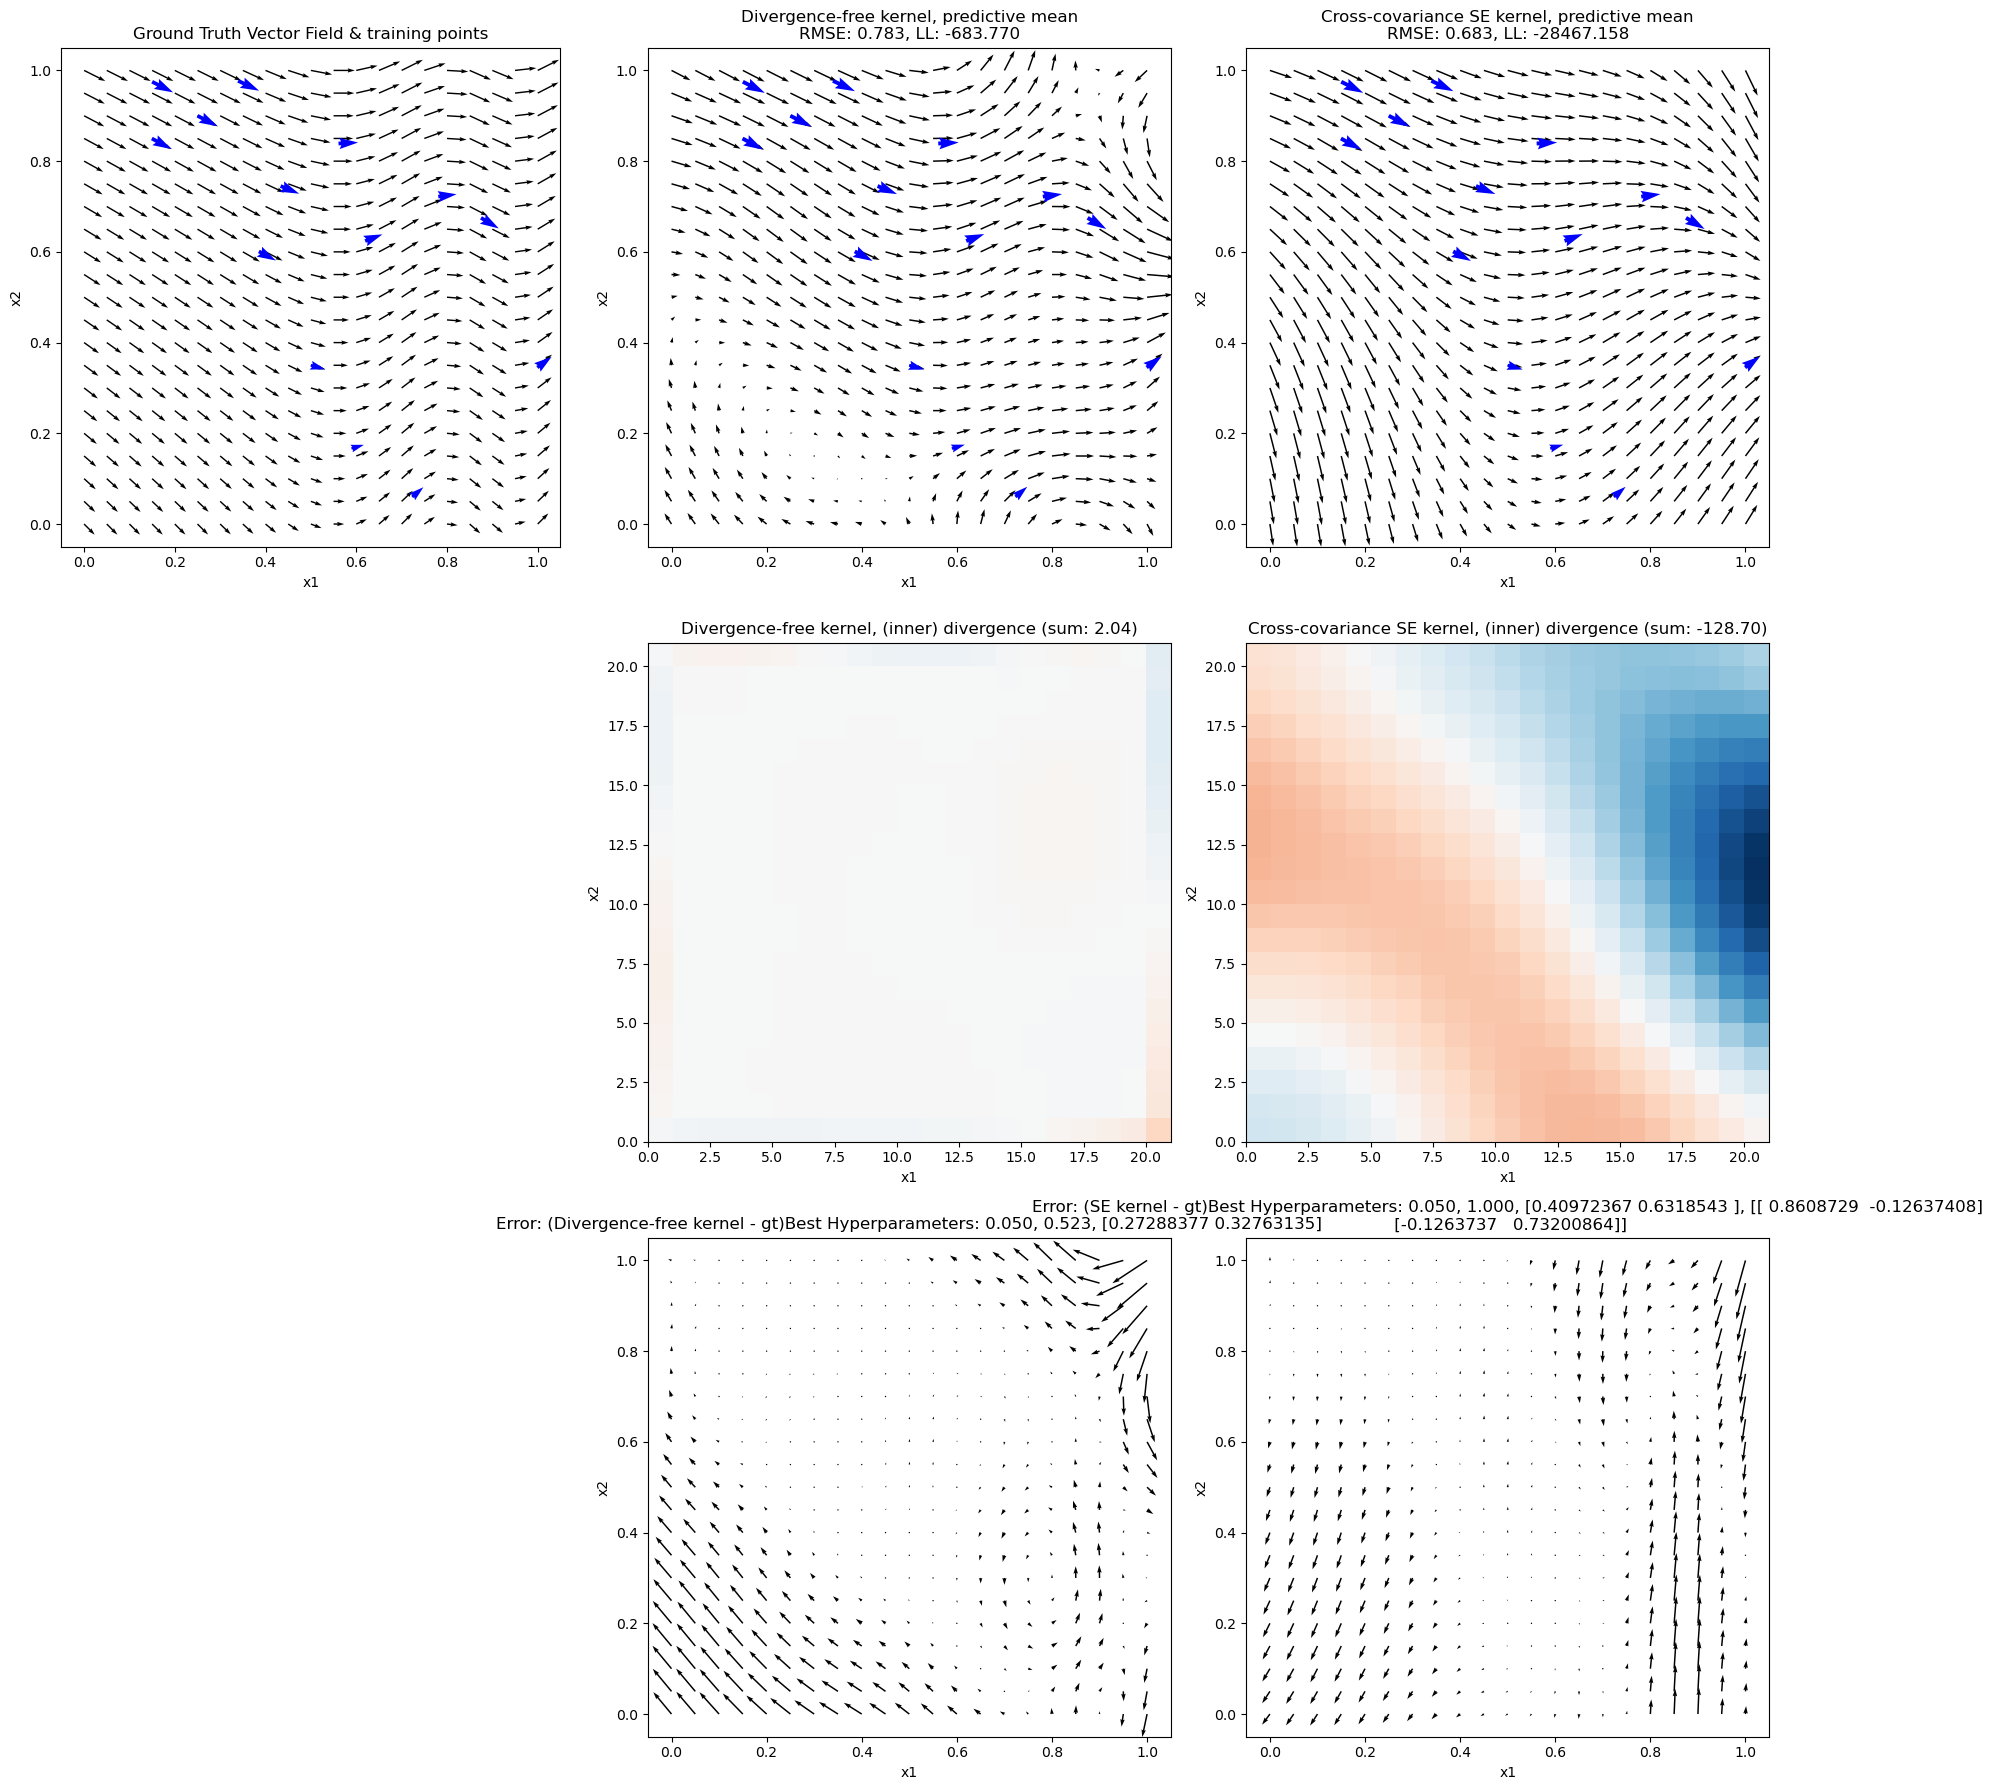

<Figure size 640x480 with 0 Axes>

In [19]:
# list of simulation functions
simulation_functions = [simulate_convergence, simulate_merge, simulate_branching, simulate_deflection, simulate_ridge]
# simulation_functions = [simulate_convergence]
# simulation_functions = [simulate_deflection]

for simulation_func in simulation_functions:

    Y_train = simulation_func(X_train)

    # Noise
    make_some_noise = torch.tensor([0.05])
    Y_train_noisy = Y_train + make_some_noise * torch.randn_like(Y_train)

    # ground truth for metrics
    Y_test = simulation_func(X_test)

    ##############################
    ### Divergence-free kernel ###
    ##############################
    print("Divergence-free kernel")
    sigma_n = torch.tensor([0.05], requires_grad = False) # no optimisation for noise
    sigma_f = torch.tensor([0.3], requires_grad = True) # initialise
    l = torch.tensor([0.7, 0.7], requires_grad = True)

    # list of 3 tensors
    initial_hyperparameters_df = [sigma_n, sigma_f, l]

    opt_hyperparameters_df, _ = optimise_hypers_on_train(
        initial_hyperparameters_df, 
        X_train, 
        Y_train_noisy, 
        X_test,
        divergence_free_bool = True)

    predictive_mean_df, predictive_covar_df, nlml_df = predict(
        X_train,
        Y_train_noisy,
        X_test, 
        opt_hyperparameters_df,
        divergence_free_bool = True)
    
    rmse_df = torch.sqrt(torch.mean(torch.square(predictive_mean_df - Y_test)))
    mae_df = torch.mean(torch.abs(predictive_mean_df - Y_test))
    ll_df = log_likelihood_test(predictive_mean_df, predictive_covar_df, Y_test)

    print(f"RMSE: {rmse_df.item():.4f}, MAE: {mae_df.item():.4f}, Log-Likelihood: {ll_df.item():.4f}")
    print()

    ##################################
    ### Squared-exponential kernel ###
    ##################################

    print("Regular SE kernel")

    # Initialise again
    sigma_n = torch.tensor([0.05], requires_grad = False)
    sigma_f = torch.tensor([1.0], requires_grad = False) # Now we fix this
    l = torch.tensor([0.7, 0.7], requires_grad = True)
    B = torch.tensor([[0.3, 0.1], [0.1, 0.3]], requires_grad = True) # fixed for now
    
    initial_hyperparameters_bd = [sigma_n, sigma_f, l, B]

    opt_hyperparameters_bd, _ = optimise_hypers_on_train(
        initial_hyperparameters_bd, 
        X_train, 
        Y_train_noisy, 
        X_test,
        divergence_free_bool = False)

    predictive_mean_bd, predictive_covar_bd, nlml_bd = predict(
        X_train,
        Y_train_noisy,
        X_test, 
        initial_hyperparameters_bd,
        divergence_free_bool = False) # other mode
    
    rmse_bd = torch.sqrt(torch.mean(torch.square(predictive_mean_bd - Y_test)))
    mae_bd = torch.mean(torch.abs(predictive_mean_bd - Y_test))
    ll_bd = log_likelihood_test(predictive_mean_bd, predictive_covar_bd, Y_test)

    print(f"RMSE: {rmse_bd.item():.4f}, MAE: {mae_bd.item():.4f}, Log-Likelihood: {ll_bd.item():.4f}")

    ############
    ### PLOT ###
    ############

    # format best hypers
    formatted_hypers_df = []
    for h in opt_hyperparameters_df:  # Use optimized hyperparameters
        h_np = h.detach().numpy()
        if h_np.ndim == 0:  # Scalar tensor
            formatted_hypers_df.append(f"{h_np:.3f}")
        elif h_np.ndim == 1 and h_np.shape[0] == 1:  # Single-element 1D tensor
            formatted_hypers_df.append(f"{h_np[0]:.3f}")
        else:  # Higher-dimensional tensors (e.g., matrices)
            formatted_hypers_df.append(str(h_np))

    # Add formatted hyperparameters to the plot
    hyperparams_text_df = f"Best Hyperparameters: {', '.join(formatted_hypers_df)}"

    # reapeat for block diagonal
    formatted_hypers_bd = []
    for h in opt_hyperparameters_bd:  # Use optimized hyperparameters
        h_np = h.detach().numpy()
        if h_np.ndim == 0:  # Scalar tensor
            formatted_hypers_bd.append(f"{h_np:.3f}")
        elif h_np.ndim == 1 and h_np.shape[0] == 1:  # Single-element 1D tensor
            formatted_hypers_bd.append(f"{h_np[0]:.3f}")
        else:  # Higher-dimensional tensors (e.g., matrices)
            formatted_hypers_bd.append(str(h_np))

    # Add formatted hyperparameters to the plot
    hyperparams_text_bd = f"Best Hyperparameters: {', '.join(formatted_hypers_bd)}"

    # includes error

    fig, axes = plt.subplots(3, 3, figsize = (18, 18))  # 3 rows, 3 columns

    training_point_color = "blue"

    # inverse scaling
    fixed_quiver_scale_factor = torch.max(torch.sqrt(Y_test[:, 0]**2 + Y_test[:, 1]**2)).item()*21

    # First plot: Ground truth vector field
    axes[0, 0].quiver(X_test[:, 0], X_test[:, 1], Y_test[:, 0], Y_test[:, 1], color = 'black', scale = fixed_quiver_scale_factor)
    axes[0, 0].quiver(X_train[:, 0], X_train[:, 1], Y_train[:, 0], Y_train[:, 1], color = training_point_color, label = 'Training Data', scale = fixed_quiver_scale_factor)
    axes[0, 0].set_title('Ground Truth Vector Field & training points')
    axes[0, 0].set_xlabel('x1')
    axes[0, 0].set_ylabel('x2')
    axes[0, 0].set_aspect('equal')

    # Second plot: Divergence-free kernel mean
    axes[0, 1].quiver(X_test[:, 0], X_test[:, 1], predictive_mean_df.detach().numpy()[:, 0], predictive_mean_df.detach().numpy()[:, 1], color = 'black', scale = fixed_quiver_scale_factor)
    axes[0, 1].quiver(X_train[:, 0], X_train[:, 1], Y_train[:, 0], Y_train[:, 1], color = training_point_color, label = 'Training Data', scale = fixed_quiver_scale_factor)
    axes[0, 1].set_title(f"Divergence-free kernel, predictive mean\nRMSE: {rmse_df:.3f}, LL: {ll_df:.3f}")
    axes[0, 1].set_xlabel('x1')
    axes[0, 1].set_ylabel('x2')

    # Third plot: SE kernel mean
    axes[0, 2].quiver(X_test[:, 0], X_test[:, 1], predictive_mean_bd.detach().numpy()[:, 0], predictive_mean_bd.detach().numpy()[:, 1], color = 'black', scale = fixed_quiver_scale_factor)
    axes[0, 2].quiver(X_train[:, 0], X_train[:, 1], Y_train[:, 0], Y_train[:, 1], color = training_point_color, label = 'Training Data', scale = fixed_quiver_scale_factor)
    axes[0, 2].set_title(f"Cross-covariance SE kernel, predictive mean\nRMSE: {rmse_bd:.3f}, LL: {ll_bd:.3f}")
    axes[0, 2].set_xlabel('x1')
    axes[0, 2].set_ylabel('x2')

    axes[1, 0].axis('off')

    # Divergence of df kernel
    U_df = predictive_mean_df.detach().numpy()[:, 0].reshape(N_grid_x1, N_grid_x2)
    V_df = predictive_mean_df.detach().numpy()[:, 1].reshape(N_grid_x1, N_grid_x2)
    div_df = np.gradient(U_df, dx, axis = 1) + np.gradient(V_df, dy, axis = 0)

    U_bd = predictive_mean_bd.detach().numpy()[:, 0].reshape(N_grid_x1, N_grid_x2)
    V_bd = predictive_mean_bd.detach().numpy()[:, 1].reshape(N_grid_x1, N_grid_x2)
    div_bd = np.gradient(U_bd, dx, axis = 1) + np.gradient(V_bd, dy, axis = 0)

    # Fix color sclae
    color_max = max(abs(np.min(div_df)), abs(np.max(div_df)), abs(np.min(div_bd)), abs(np.max(div_bd)))
    color_min = - color_max

    axes[1, 1].pcolormesh(div_df, cmap = 'RdBu_r', vmin = - color_max, vmax = color_max)
    axes[1, 1].set_title(f'Divergence-free kernel, (inner) divergence (sum: {np.sum(div_df[1:-1, 1:-1]):.2f})')
    axes[1, 1].set_xlabel('x1')
    axes[1, 1].set_ylabel('x2')

    axes[1, 2].pcolormesh(div_bd, cmap = 'RdBu_r', vmin = - color_max, vmax = color_max)
    axes[1, 2].set_title(f'Cross-covariance SE kernel, (inner) divergence (sum: {np.sum(div_bd[1:-1, 1:-1]):.2f})')
    axes[1, 2].set_xlabel('x1')
    axes[1, 2].set_ylabel('x2')

    axes[2, 0].axis('off')

    # Quiver distance, quiver scale is fixed
    axes[2, 1].quiver(X_test[:, 0], X_test[:, 1], (predictive_mean_df.detach().numpy()[:, 0] - Y_test[:, 0].numpy()), (predictive_mean_df.detach().numpy()[:, 1] - Y_test[:, 1].numpy()), color = 'black', scale = fixed_quiver_scale_factor)
    axes[2, 1].set_title(f'Error: (Divergence-free kernel - gt)' + hyperparams_text_df)
    axes[2, 1].set_xlabel('x1')
    axes[2, 1].set_ylabel('x2')

    axes[2, 2].quiver(X_test[:, 0], X_test[:, 1], (predictive_mean_bd.detach().numpy()[:, 0] - Y_test[:, 0].numpy()), (predictive_mean_bd.detach().numpy()[:, 1] - Y_test[:, 1].numpy()), color = 'black', scale = fixed_quiver_scale_factor)
    axes[2, 2].set_title(f'Error: (SE kernel - gt)' + hyperparams_text_bd)
    axes[2, 2].set_xlabel('x1')
    axes[2, 2].set_ylabel('x2')

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()
 
    plt.tight_layout()  # Adjust layout for better spacing

    output_folder = "images/experiments_cc_both_l2d_sameinitialhypers/"
    plot_filename = os.path.join(output_folder, f"experiments_{simulation_func.__name__}.png")
    plt.savefig(plot_filename)

    plt.show()

In [ ]:
dot = torch.mul(predictive_mean_bd[:, 0], predictive_mean_bd[:, 1])
torch.norm(predictive_mean_bd[:, 0])

In [ ]:
(predictive_mean_bd[:, 0] - predictive_mean_bd[:, 1]).min()

dot_product = np.dot(u, v)

# Compute magnitudes (norms)
norm_u = np.linalg.norm(u)
norm_v = np.linalg.norm(v)

# Compute angle in radians
theta_radians = np.arccos(dot_product / (norm_u * norm_v))

# Convert to degrees
theta_degrees = np.degrees(theta_radians)

# Visualise error

- fixed quiver scale

In [ ]:
    fig, axes = plt.subplots(3, 3, figsize = (18, 18))  # 3 rows, 3 columns

    training_point_color = "blue"

    # inverse scaling
    fixed_quiver_scale_factor = torch.max(torch.sqrt(Y_test[:, 0]**2 + Y_test[:, 1]**2)).item()*21

    # First plot: Ground truth vector field
    axes[0, 0].quiver(X_test[:, 0], X_test[:, 1], Y_test[:, 0], Y_test[:, 1], color = 'black', scale = fixed_quiver_scale_factor)
    axes[0, 0].quiver(X_train[:, 0], X_train[:, 1], Y_train[:, 0], Y_train[:, 1], color = training_point_color, label = 'Training Data', scale = fixed_quiver_scale_factor)
    axes[0, 0].set_title('Ground Truth Vector Field & training points')
    axes[0, 0].set_xlabel('x1')
    axes[0, 0].set_ylabel('x2')
    axes[0, 0].set_aspect('equal')

    # Second plot: Divergence-free kernel mean
    axes[0, 1].quiver(X_test[:, 0], X_test[:, 1], predictive_mean_df.detach().numpy()[:, 0], predictive_mean_df.detach().numpy()[:, 1], color = 'black', scale = fixed_quiver_scale_factor)
    axes[0, 1].quiver(X_train[:, 0], X_train[:, 1], Y_train[:, 0], Y_train[:, 1], color = training_point_color, label = 'Training Data', scale = fixed_quiver_scale_factor)
    axes[0, 1].set_title(f"Divergence-free kernel, predictive mean\nRMSE: {rmse_df:.3f}, LL: {ll_df:.3f}")
    axes[0, 1].set_xlabel('x1')
    axes[0, 1].set_ylabel('x2')

    # Third plot: SE kernel mean
    axes[0, 2].quiver(X_test[:, 0], X_test[:, 1], predictive_mean_bd.detach().numpy()[:, 0], predictive_mean_bd.detach().numpy()[:, 1], color = 'black', scale = fixed_quiver_scale_factor)
    axes[0, 2].quiver(X_train[:, 0], X_train[:, 1], Y_train[:, 0], Y_train[:, 1], color = training_point_color, label = 'Training Data', scale = fixed_quiver_scale_factor)
    axes[0, 2].set_title(f"Block diagonal SE kernel, predictive mean\nRMSE: {rmse_bd:.3f}, LL: {ll_bd:.3f}")
    axes[0, 2].set_xlabel('x1')
    axes[0, 2].set_ylabel('x2')

    axes[1, 0].axis('off')

    # Divergence of df kernel
    U_df = predictive_mean_df.detach().numpy()[:, 0].reshape(N_grid_x1, N_grid_x2)
    V_df = predictive_mean_df.detach().numpy()[:, 1].reshape(N_grid_x1, N_grid_x2)
    div_df = np.gradient(U_df, dx, axis = 1) + np.gradient(V_df, dy, axis = 0)

    U_bd = predictive_mean_bd.detach().numpy()[:, 0].reshape(N_grid_x1, N_grid_x2)
    V_bd = predictive_mean_bd.detach().numpy()[:, 1].reshape(N_grid_x1, N_grid_x2)
    div_bd = np.gradient(U_bd, dx, axis = 1) + np.gradient(V_bd, dy, axis = 0)

    color_max = max(abs(np.min(div_df)), abs(np.max(div_df)), abs(np.min(div_bd)), abs(np.max(div_bd)))
    color_min = - color_max

    axes[1, 1].pcolormesh(div_df, cmap = 'RdBu_r', vmin = - color_max, vmax = color_max)
    axes[1, 1].set_title(f'Divergence-free kernel, (inner) divergence (sum: {np.sum(div_df[1:-1, 1:-1]):.2f})')
    axes[1, 1].text(0.05, 0.95, hyperparams_text_df, transform = axes[1].transAxes, fontsize = 12, verticalalignment = 'top', color = 'black', bbox = dict(facecolor='white', edgecolor = 'black', boxstyle = 'round, pad=0.5'))
    axes[1, 1].set_xlabel('x1')
    axes[1, 1].set_ylabel('x2')

    axes[1, 2].pcolormesh(div_bd, cmap = 'RdBu_r', vmin = - color_max, vmax = color_max)
    axes[1, 2].set_title(f'SE kernel, (inner) divergence (sum: {np.sum(div_bd[1:-1, 1:-1]):.2f})')
    axes[1, 2].text(0.05, 0.95, hyperparams_text_bd, transform = axes[1].transAxes, fontsize = 12, verticalalignment = 'top', color = 'black', bbox = dict(facecolor='white', edgecolor = 'black', boxstyle = 'round, pad=0.5'))
    axes[1, 2].set_xlabel('x1')
    axes[1, 2].set_ylabel('x2')

    axes[2, 0].axis('off')

    # Quiver distance, quiver scale is fixed
    axes[2, 1].quiver(X_test[:, 0], X_test[:, 1], (predictive_mean_df.detach().numpy()[:, 0] - Y_test[:, 0].numpy()), (predictive_mean_df.detach().numpy()[:, 1] - Y_test[:, 1].numpy()), color = 'black', scale = fixed_quiver_scale_factor)
    axes[2, 1].set_title(f'Error: (Divergence-free kernel - gt)')
    axes[2, 1].set_xlabel('x1')
    axes[2, 1].set_ylabel('x2')

    axes[2, 2].quiver(X_test[:, 0], X_test[:, 1], (predictive_mean_bd.detach().numpy()[:, 0] - Y_test[:, 0].numpy()), (predictive_mean_bd.detach().numpy()[:, 1] - Y_test[:, 1].numpy()), color = 'black', scale = fixed_quiver_scale_factor)
    axes[2, 2].set_title(f'Error: (SE kernel - gt)')
    axes[2, 2].set_xlabel('x1')
    axes[2, 2].set_ylabel('x2')

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()

# Results

- could sample number of training points
- could sample initial hypers

In [46]:
sampling_iterations = 20
# 20 take 7.5 minutes to run for one sim
# simulation_functions = [simulate_branching]
simulation_functions = [simulate_deflection]

results_dict = {}

for simulation_func in simulation_functions:

    sim_func_name = simulation_func.__name__ + "_results_tensor"
    # Initialise empty tensor
    results_tensor = torch.zeros((sampling_iterations, 4*2))
    results_dict[sim_func_name] = results_tensor

    # ground truth for metrics (only once, X_test is fixed)
    Y_test = simulation_func(X_test)

    for i in range(sampling_iterations):

        # we can also vary the number of training points
        n_train = 14

        # sample new points every time
        X_train = torch.rand(n_train, 2)
        Y_train = simulation_func(X_train)

        # Add Noise
        make_some_noise = torch.tensor([0.00])
        Y_train_noisy = Y_train + make_some_noise * torch.randn_like(Y_train)

        ##############################
        ### Divergence-free kernel ###
        ##############################

        sigma_n = torch.tensor([0.05], requires_grad = False) # no optimisation for noise
        sigma_f = torch.tensor([0.3], requires_grad = True) # initialise
        l = torch.tensor([0.7, 0.7], requires_grad = True)
        initial_hyperparameters_df = [sigma_n, sigma_f, l]

        opt_hyperparameters_df, _ = optimise_hypers_on_train(
            initial_hyperparameters_df, 
            X_train, 
            Y_train_noisy, 
            X_test,
            divergence_free_bool = True,
            max_optimisation_iterations = 1000, # default was 2000, cutting it down
            patience = 20,
            learning_rate = 0.001)

        predictive_mean_df, predictive_covar_df, nlml_df = predict(
            X_train,
            Y_train_noisy,
            X_test, 
            opt_hyperparameters_df,
            divergence_free_bool = True)
        
        # Metrics on test
        rmse_df = torch.sqrt(torch.mean(torch.square(predictive_mean_df - Y_test)))
        mae_df = torch.mean(torch.abs(predictive_mean_df - Y_test))
        nll_df = - log_likelihood_test(predictive_mean_df, predictive_covar_df, Y_test)
        # divergence
        U_df = predictive_mean_df.detach().numpy()[:, 0].reshape(N_grid_x1, N_grid_x2)
        V_df = predictive_mean_df.detach().numpy()[:, 1].reshape(N_grid_x1, N_grid_x2)
        divergence_df = np.sum(np.gradient(U_df, dx, axis = 1) + np.gradient(V_df, dy, axis = 0))

        print(f"RMSE: {rmse_df.item():.4f}, MAE: {mae_df.item():.4f}, Log-Likelihood: {ll_df.item():.4f}")
        print()

        ##################################
        ### Squared-exponential kernel ###
        ##################################

        # Initialise again
        sigma_n = torch.tensor([0.05], requires_grad = False)
        sigma_f = torch.tensor([1.0], requires_grad = False) # Now we fix this
        l = torch.tensor([0.7, 0.7], requires_grad = True)
        B = torch.tensor([[0.3, 0.1], [0.1, 0.3]], requires_grad = True) # fixed for now
        initial_hyperparameters_bd = [sigma_n, sigma_f, l, B]

        opt_hyperparameters_bd, _ = optimise_hypers_on_train(
            initial_hyperparameters_bd, 
            X_train, 
            Y_train_noisy, 
            X_test,
            divergence_free_bool = False,
            max_optimisation_iterations = 1000, # default was 2000, cutting it down
            patience = 20,
            learning_rate = 0.001)

        predictive_mean_bd, predictive_covar_bd, nlml_bd = predict(
            X_train,
            Y_train_noisy,
            X_test, 
            initial_hyperparameters_bd,
            divergence_free_bool = False) # other mode
    
        rmse_bd = torch.sqrt(torch.mean(torch.square(predictive_mean_bd - Y_test)))
        mae_bd = torch.mean(torch.abs(predictive_mean_bd - Y_test))
        # Negative ll so that for all metrics lower is better
        nll_bd = - log_likelihood_test(predictive_mean_bd, predictive_covar_bd, Y_test)

        # divergence
        U_bd = predictive_mean_bd.detach().numpy()[:, 0].reshape(N_grid_x1, N_grid_x2)
        V_bd = predictive_mean_bd.detach().numpy()[:, 1].reshape(N_grid_x1, N_grid_x2)
        divergence_bd = np.sum(np.gradient(U_bd, dx, axis = 1) + np.gradient(V_bd, dy, axis = 0))

        results_dict[sim_func_name][i] = torch.tensor([
            rmse_df, mae_df, nll_df, divergence_df, 
            rmse_bd, mae_bd, nll_bd, divergence_bd])

Initial hyperparameters: 0.050, 0.300, [0.7 0.7]
Initial LML (higher is better): -39.97

Optimisation complete after 1000/1000 iterations. Maybe consider adjusting the optimisation scheme (e.g. learning rate, max iterations, patience, etc.).
Best hyperparameters: 0.050, 0.596, [0.5738596  0.52351415]
Best LML (higher is better): 15.01
RMSE: 0.2102, MAE: 0.0999, Log-Likelihood: -1324.4885

Initial hyperparameters: 0.050, 1.000, [0.7 0.7], [[0.3 0.1]
 [0.1 0.3]]
Initial LML (higher is better): -10.75

Optimisation complete after 1000/1000 iterations. Maybe consider adjusting the optimisation scheme (e.g. learning rate, max iterations, patience, etc.).
Best hyperparameters: 0.050, 1.000, [0.65122503 0.6872067 ], [[ 0.69075316 -0.19247432]
 [-0.19247426  0.6133286 ]]
Best LML (higher is better): 13.17
Initial hyperparameters: 0.050, 0.300, [0.7 0.7]
Initial LML (higher is better): 4.34

Optimisation complete after 1000/1000 iterations. Maybe consider adjusting the optimisation scheme (e.g.

# Bar chart

Change it to absolute divergence so that lower is better too?
- Change to absolute 

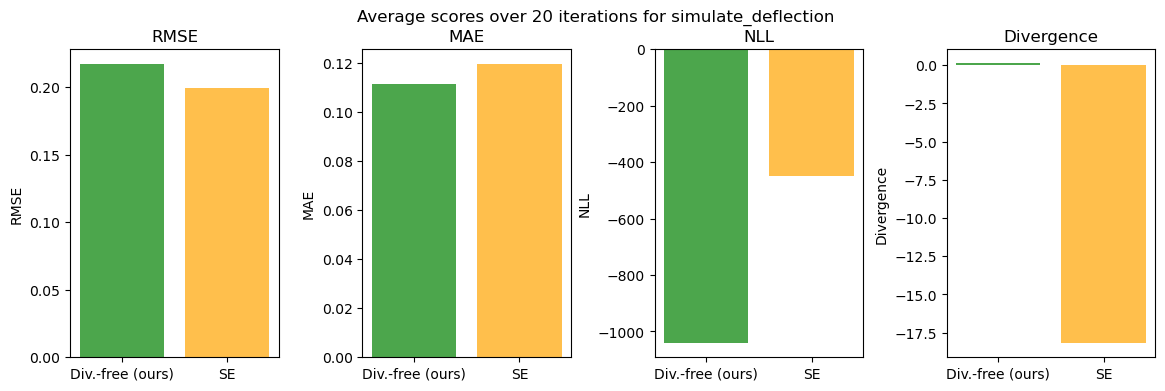

In [47]:
for simulation_func in simulation_functions:

    sim_func_name = simulation_func.__name__ + "_results_tensor"

    # Average scores over all iterations
    df_average_results = results_dict[sim_func_name].mean(dim = 0)[0:4]
    bd_average_results = results_dict[sim_func_name].mean(dim = 0)[4:8]

    methods = ["Divergence-free kernel", "Block diagonal SE kernel"]
    metrics = ["RMSE", "MAE", "NLL", "Divergence"]
    x = np.arange(len(metrics))
    width = 0.35  # Width of bars

    fig, axes = plt.subplots(1, 4, figsize = (14, 4), sharex=False)

    for i, metric in enumerate(metrics):
        axes[i].bar([0, 1], [df_average_results[i], bd_average_results[i]], color = ['green', 'orange'], alpha=0.7)
        axes[i].set_title(metric)
        axes[i].set_xticks([0, 1])
        axes[i].set_xticklabels(["Div.-free (ours)", "SE"])
        axes[i].set_ylabel(metric)

    plt.subplots_adjust(wspace = 0.4) # Space horizontally between subplots
    plt.suptitle(f"Average scores over {sampling_iterations} iterations for {simulation_func.__name__}")
    plt.show()

# Boxplots

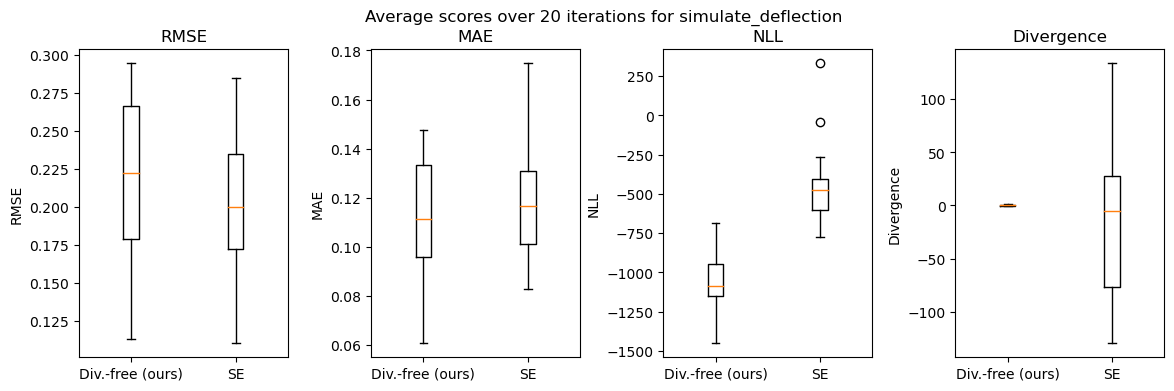

In [57]:
simulation_functions = [simulate_deflection]
for simulation_func in simulation_functions:

    sim_func_name = simulation_func.__name__ + "_results_tensor"

    # Average scores over all iterations
    df_average_results = results_dict[sim_func_name].mean(dim = 0)[0:4]
    bd_average_results = results_dict[sim_func_name].mean(dim = 0)[4:8]

    methods = ["Divergence-free kernel", "Block diagonal SE kernel"]
    metrics = ["RMSE", "MAE", "NLL", "Divergence"]
    x = np.arange(len(metrics))
    width = 0.35  # Width of bars

    fig, axes = plt.subplots(1, 4, figsize = (14, 4), sharex=False)

    for i, metric in enumerate(metrics):
        data = [results_dict[sim_func_name][:, i].numpy(),  # Divergence-free
            results_dict[sim_func_name][:, i + 4].numpy()]
        # [df_average_results[i], bd_average_results[i]]
        axes[i].boxplot(data)
        axes[i].set_title(metric)
        axes[i].set_xticks([1, 2])
        axes[i].set_xticklabels(["Div.-free (ours)", "SE"])
        axes[i].set_ylabel(metric)

    plt.subplots_adjust(wspace = 0.4) # Space horizontally between subplots
    plt.suptitle(f"Average scores over {sampling_iterations} iterations for {simulation_func.__name__}")
    plt.show()

# Sample

In [ ]:
predictive_mean

In [ ]:
posterior = torch.distributions.MultivariateNormal(
        loc = predictive_mean.squeeze(), 
        covariance_matrix = predictive_covariance + 1e-5 * torch.eye(predictive_covariance.size(0)))

samples = posterior.sample((4,))

In [ ]:
# multivariate GP: Variance-covariance matrix (full block covariance) (n, 2, n, 2) 
# (n, 2, 2)
n_test = X_test.shape[0]

predictive_covar[:n_test, :n_test].mean()

# upper right
predictive_covar[:n_test, n_test:].mean()
predictive_covar[:n_test, n_test:].max()

# lower left
predictive_covar[n_test:, :n_test].mean()

# variance
# torch.diag(predictive_covar)[n_test:].mean()
# variance
# torch.diag(predictive_covar)[:n_test].mean()
torch.diag(predictive_covar)[:n_test].max()